# Make figures 4, 5, 6
4 Western GNSS/satellite/ICESat-2 graph\
5 Eastern GNSS/satellite/ICESat-2 graph\
6 Opening rate graph

In [1]:
import pickle
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import math
import shapefile
import xarray as xr 
import rioxarray as rio
from rasterio.plot import show
from rasterio.merge import merge
from matplotlib.patches import Rectangle
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy import stats
from scipy.stats import linregress
from netCDF4 import Dataset    
from pyproj import Transformer, Geod

In [2]:
figure_folder = 'figures/'
data_folder = 'data/'
HCobs_path = '/home/ram21/notebooks/brunt-is2-rifts/brunt_himedlow_mdt_halloween_merged.pickle'
satellite_path = '/home/ram21/notebooks/brunt-is2-rifts/halloween/'

## Load Rift Measurements from Optical Imagery

In [3]:
satellite_obs_283 = pd.read_csv('data/satellite_obs_283.csv') # DigitalGlobe_283_1l
satellite_obs_725 = pd.read_csv('data/satellite_obs_725.csv') # DigitalGlobe_725_3l
satellite_obs_215 = pd.read_csv('data/satellite_obs_215.csv') # DigitalGlobe_215_1l
satellite_obs_1160 = pd.read_csv('data/satellite_obs_1160.csv') # DigitalGlobe_1160
satellite_obs_1099 = pd.read_csv('data/satellite_obs_1099.csv') # DigitalGlobe_1099_2l
satellite_obs_786 = pd.read_csv('data/satellite_obs_786.csv') # DigitalGlobe_786_2l

## Load ICESat-2 rift observations

In [4]:
with open(HCobs_path, 'rb') as handle:
    halloween_obs_merged = pickle.load(handle)


<ipython-input-4-4575231721a9>:2: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  halloween_obs_merged = pickle.load(handle)


In [5]:
transformer_ps2latlon = Transformer.from_crs("EPSG:3031", "EPSG:4326")
transformer_latlon2ps = Transformer.from_crs("EPSG:4326", "EPSG:3031")
geodesic = Geod(ellps='WGS84')

# Load GNSS observations
Global Navigation Satellite System monthly position/time observations from GNSS receivers hh00 and tt05 ("western pair") and ss00 and tt04 ("eastern pair") across Halloween Crack (see Supplementary figures 2 and 3). A small number of observations are removed so receivers within each pair have the same time vectors. The data were processed in the notebook analyze_gps.ipynb.

In [34]:
import pickle

# Load the pickle file and automatically assign variables to the workspace
with open(data_folder + '/processed-gps.pkl', 'rb') as f:
    loaded_variables = pickle.load(f)

# Dynamically load all variables into the workspace
globals().update(loaded_variables)

print("All variables have been loaded successfully.")

All variables have been loaded successfully.


# Load Landsat imagery

In [7]:
landsat_out_B2 = '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_184114_20200220_B2_merge.tif'
landsat_out_B3 = '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_184114_20200220_B3_merge.tif'
landsat_out_B4 = '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_184114_20200220_B4_merge.tif'

landsat_names_B2 = ['/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_20200220_20201016_02_T2/LC08_L1GT_184113_20200220_20201016_02_T2_B2.TIF',
                    '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184114_20200220_20201016_02_T2/LC08_L1GT_184114_20200220_20201016_02_T2_B2.TIF']
 
landsat_names_B3 = ['/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_20200220_20201016_02_T2/LC08_L1GT_184113_20200220_20201016_02_T2_B3.TIF',
                    '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184114_20200220_20201016_02_T2/LC08_L1GT_184114_20200220_20201016_02_T2_B3.TIF']
  
landsat_names_B4 = ['/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_20200220_20201016_02_T2/LC08_L1GT_184113_20200220_20201016_02_T2_B4.TIF',
                    '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184114_20200220_20201016_02_T2/LC08_L1GT_184114_20200220_20201016_02_T2_B4.TIF']

B2_files_to_mosaic = []
B3_files_to_mosaic = []
B4_files_to_mosaic = []

for fp2 in landsat_names_B2:
    src2 = rasterio.open(fp2)
    B2_files_to_mosaic.append(src2)
    
mosaic_B2, out_trans_B2 = merge(B2_files_to_mosaic)

for fp3 in landsat_names_B3:
    src3 = rasterio.open(fp3)
    B3_files_to_mosaic.append(src3)
    
mosaic_B3, out_trans_B3 = merge(B3_files_to_mosaic)

for fp4 in landsat_names_B4:
    src4 = rasterio.open(fp4)
    B4_files_to_mosaic.append(src4)

mosaic_B4, out_trans_B4 = merge(B4_files_to_mosaic)

out_meta = src2.meta.copy()
out_meta.update({'driver': 'GTiff',
                 'dtype': 'uint16',
                 'nodata': 0.0,
                 'width': mosaic_B2.shape[2],
                 'height': mosaic_B2.shape[1],
                 'count': 1,
                 'transform': out_trans_B2
                })
    
with rasterio.open(landsat_out_B2, "w", **out_meta) as dest:
    dest.write(mosaic_B2)
    
with rasterio.open(landsat_out_B3, "w", **out_meta) as dest:    
    dest.write(mosaic_B3)
    
with rasterio.open(landsat_out_B4, "w", **out_meta) as dest:   
    dest.write(mosaic_B4)    

img1_2 = rasterio.open(landsat_out_B2)
img1_3 = rasterio.open(landsat_out_B3)
img1_4 = rasterio.open(landsat_out_B4)

# crop to 99th percentile (stops dull images)
image1_2 = img1_2.read(1)
image1_2[image1_2 > np.percentile(image1_2,99)] = np.percentile(image1_2,99)
image1_3 = img1_3.read(1)
image1_3[image1_3 > np.percentile(image1_3,99)] = np.percentile(image1_3,99)
image1_4 = img1_4.read(1)
image1_4[image1_4 > np.percentile(image1_4,99)] = np.percentile(image1_4,99)

image1 = np.array([image1_4, image1_3, image1_2]).transpose(1,2,0)
norm1 = (image1 * (255 / np.max(image1))).astype(np.uint8)



## Define rotation to rift coordinates

In [8]:
def estimate_local_rift_orientation_new(pt,x,y):
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    if closest == 0:
        #print(closest)
        #the closest is the first point of the rift, so must be (c to c+1)
        [latc1,longc1] = transformer_ps2latlon.transform( x[closest] , y[closest] )
        [latc2,longc2] = transformer_ps2latlon.transform( x[closest+1] , y[closest+1] )
        fwd_azimuth,back_azimuth,distance = geodesic.inv(longc1, latc1, longc2, latc2)
    elif closest == len(x)-1:
        #print(closest-1)
        #the closest is the last point of the rift, so must be previous (c-1 to c)
        [latp1,longp1] = transformer_ps2latlon.transform( x[closest-1] , y[closest-1] )
        [latc1,longc1] = transformer_ps2latlon.transform( x[closest] , y[closest] )
        fwd_azimuth,back_azimuth,distance = geodesic.inv(longp1, latp1, longc1, latc1)
    else:
        #the closest is not the first or last, so could be (c-1 to c) or (c to c+1)
        #lat long of rift segments surrounding the closest, and the point
        [latp1,longp1] = transformer_ps2latlon.transform( x[closest-1] , y[closest-1] )
        [latc1,longc1] = transformer_ps2latlon.transform( x[closest] , y[closest] )
        [latc2,longc2] = transformer_ps2latlon.transform( x[closest+1] , y[closest+1] )
        [latpt,longpt] = transformer_ps2latlon.transform( pt.x , pt.y )
        fwd_azimuth_prev,back_azimuth_prev,distance_prev = geodesic.inv(longp1, latp1, longc1, latc1)
        fwd_azimuth_clo,back_azimuth_clo,distance_clo = geodesic.inv(longc1, latc1, longc2, latc2)
        fwd_azimuth_pt,back_azimuth_pt,distance_pt = geodesic.inv(longc1, latc1, longpt, latpt)
        new_zero = np.mean([back_azimuth_prev,fwd_azimuth_clo])
        new_zero_pt = fwd_azimuth_pt - new_zero
        if new_zero_pt > 0:
            #print(closest)
            fwd_azimuth = fwd_azimuth_clo
        elif new_zero_pt < 0:
            #print(closest-1)
            fwd_azimuth = fwd_azimuth_prev 
    return fwd_azimuth


### Dates
Halloween Crack found\
North Rift propagating\
North Rift calved\
ICESat-2 launch

In [9]:
HC_found = 2016 + ((10-1)/12) + ((31-1)/365) 
NR_found = 2020 + ((11-1)/12) + ((1-1)/365)
NR_calve = 2021 + ((2-1)/12) + ((26-1)/365)
IS_start = 2018 + ((10-1)/12) + ((14-1)/365)


## Load shapefiles for plots

In [10]:
rift_path = pickle.load( open( '/data/fast1/arc/feature_outlines/halloween_path.pickle', "rb" ) )
riftx,rifty = np.array(rift_path.xy)

# Loading DataFrames from Parquet files
shapefile1L_ar = pd.read_parquet('data/shapefile1L_ar.parquet')
shapefile1R_ar = pd.read_parquet('data/shapefile1R_ar.parquet')
shapefile2L_ar = pd.read_parquet('data/shapefile2L_ar.parquet')
shapefile2R_ar = pd.read_parquet('data/shapefile2R_ar.parquet')
shapefile3L_ar = pd.read_parquet('data/shapefile3L_ar.parquet')
shapefile3R_ar = pd.read_parquet('data/shapefile3R_ar.parquet')

print("DataFrames loaded successfully.")

DataFrames loaded successfully.


<ipython-input-10-988c873604d5>:1: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  rift_path = pickle.load( open( '/data/fast1/arc/feature_outlines/halloween_path.pickle', "rb" ) )


## Figure 3
Along 215 1LR, 1160 3LR, 786 2LR: plot of comparison between GPS, ICESat-2, Landsat-8, WorldView

### subset detections

In [11]:
halloween_obs_merged_215_1l = halloween_obs_merged[(halloween_obs_merged["rgt"]==215) & (halloween_obs_merged["beam"]=='1l')]
halloween_obs_merged_215_1r = halloween_obs_merged[(halloween_obs_merged["rgt"]==215) & (halloween_obs_merged["beam"]=='1r')]

halloween_obs_merged_215_1l = gpd.GeoDataFrame(
    halloween_obs_merged_215_1l, geometry=gpd.points_from_xy(halloween_obs_merged_215_1l['x-centroid'], halloween_obs_merged_215_1l['y-centroid']))
halloween_obs_merged_215_1r = gpd.GeoDataFrame(
    halloween_obs_merged_215_1r, geometry=gpd.points_from_xy(halloween_obs_merged_215_1r['x-centroid'], halloween_obs_merged_215_1r['y-centroid']))
    
#display(halloween_obs_merged_215_1l)
#display(halloween_obs_merged_215_1r)

halloween_obs_merged_1160_3l = halloween_obs_merged[(halloween_obs_merged["rgt"]==1160) & (halloween_obs_merged["beam"]=='3l')]
halloween_obs_merged_1160_3r = halloween_obs_merged[(halloween_obs_merged["rgt"]==1160) & (halloween_obs_merged["beam"]=='3r')]

halloween_obs_merged_1160_3l = gpd.GeoDataFrame(
    halloween_obs_merged_1160_3l, geometry=gpd.points_from_xy(halloween_obs_merged_1160_3l['x-centroid'], halloween_obs_merged_1160_3l['y-centroid']))
halloween_obs_merged_1160_3r = gpd.GeoDataFrame(
    halloween_obs_merged_1160_3r, geometry=gpd.points_from_xy(halloween_obs_merged_1160_3r['x-centroid'], halloween_obs_merged_1160_3r['y-centroid']))

#display(halloween_obs_merged_1160_3l)
#display(halloween_obs_merged_1160_3r)

halloween_obs_merged_786_2l = halloween_obs_merged[(halloween_obs_merged["rgt"]==786) & (halloween_obs_merged["beam"]=='2l')]
halloween_obs_merged_786_2r = halloween_obs_merged[(halloween_obs_merged["rgt"]==786) & (halloween_obs_merged["beam"]=='2r')]

halloween_obs_merged_786_2l = gpd.GeoDataFrame(
    halloween_obs_merged_786_2l, geometry=gpd.points_from_xy(halloween_obs_merged_786_2l['x-centroid'], halloween_obs_merged_786_2l['y-centroid']))
halloween_obs_merged_786_2r = gpd.GeoDataFrame(
    halloween_obs_merged_786_2r, geometry=gpd.points_from_xy(halloween_obs_merged_786_2r['x-centroid'], halloween_obs_merged_786_2r['y-centroid']))
    
#display(halloween_obs_merged_786_2l)
#display(halloween_obs_merged_786_2r)
# display(halloween_obs_merged_1160_3l)


### rotate to rift coordinates

In [12]:
azimuth_1l = []

for index, row in halloween_obs_merged_215_1l.iterrows():
    azimuth_1l.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_1l = np.abs(np.sin(np.deg2rad(azimuth_1l - halloween_obs_merged_215_1l['azimuth']))) * halloween_obs_merged_215_1l['width']
actual_non_iceberg_width_1l = np.abs(np.sin(np.deg2rad(azimuth_1l - halloween_obs_merged_215_1l['azimuth']))) * halloween_obs_merged_215_1l['non-iceberg-width']

azimuth_1r = []

for index, row in halloween_obs_merged_215_1r.iterrows():    
    azimuth_1r.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_1r = np.abs(np.sin(np.deg2rad(azimuth_1r - halloween_obs_merged_215_1r['azimuth']))) * halloween_obs_merged_215_1r['width']
actual_non_iceberg_width_1r = np.abs(np.sin(np.deg2rad(azimuth_1r - halloween_obs_merged_215_1r['azimuth']))) * halloween_obs_merged_215_1r['non-iceberg-width']

azimuth_3l = []

for index, row in halloween_obs_merged_1160_3l.iterrows():
    azimuth_3l.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_3l = np.abs(np.sin(np.deg2rad(azimuth_3l - halloween_obs_merged_1160_3l['azimuth']))) * halloween_obs_merged_1160_3l['width']
actual_non_iceberg_width_3l = np.abs(np.sin(np.deg2rad(azimuth_3l - halloween_obs_merged_1160_3l['azimuth']))) * halloween_obs_merged_1160_3l['non-iceberg-width']

azimuth_3r = []

for index, row in halloween_obs_merged_1160_3r.iterrows():
    azimuth_3r.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_3r = np.abs(np.sin(np.deg2rad(azimuth_3r - halloween_obs_merged_1160_3r['azimuth']))) * halloween_obs_merged_1160_3r['width']
actual_non_iceberg_width_3r = np.abs(np.sin(np.deg2rad(azimuth_3r - halloween_obs_merged_1160_3r['azimuth']))) * halloween_obs_merged_1160_3r['non-iceberg-width']

azimuth_786_2l = []

for index, row in halloween_obs_merged_786_2l.iterrows():
    azimuth_786_2l.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_786_2l = np.abs(np.sin(np.deg2rad(azimuth_786_2l - halloween_obs_merged_786_2l['azimuth']))) * halloween_obs_merged_786_2l['width']
actual_non_iceberg_width_786_2l = np.abs(np.sin(np.deg2rad(azimuth_786_2l - halloween_obs_merged_786_2l['azimuth']))) * halloween_obs_merged_786_2l['non-iceberg-width']

azimuth_786_2r = []

for index, row in halloween_obs_merged_786_2r.iterrows():    
    azimuth_786_2r.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_786_2r = np.abs(np.sin(np.deg2rad(azimuth_786_2r - halloween_obs_merged_786_2r['azimuth']))) * halloween_obs_merged_786_2r['width']
actual_non_iceberg_width_786_2r = np.abs(np.sin(np.deg2rad(azimuth_786_2r - halloween_obs_merged_786_2r['azimuth']))) * halloween_obs_merged_786_2r['non-iceberg-width']


halloween_obs_merged_215_1l['rift-angle'] = pd.Series(np.array(azimuth_1l), index=halloween_obs_merged_215_1l.index)
halloween_obs_merged_215_1r['rift-angle'] = pd.Series(np.array(azimuth_1r), index=halloween_obs_merged_215_1r.index)
halloween_obs_merged_215_1l["actual-width"] = pd.Series(np.array(actual_width_1l), index=halloween_obs_merged_215_1l.index)
halloween_obs_merged_215_1r["actual-width"] = pd.Series(np.array(actual_width_1r), index=halloween_obs_merged_215_1r.index)
halloween_obs_merged_215_1l["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_1l), index=halloween_obs_merged_215_1l.index)
halloween_obs_merged_215_1r["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_1r), index=halloween_obs_merged_215_1r.index)

#display(halloween_obs_merged_215_1l)
#display(halloween_obs_merged_215_1r)

halloween_obs_merged_1160_3l['rift-angle'] = pd.Series(np.array(azimuth_3l), index=halloween_obs_merged_1160_3l.index)
halloween_obs_merged_1160_3r['rift-angle'] = pd.Series(np.array(azimuth_3r), index=halloween_obs_merged_1160_3r.index)
halloween_obs_merged_1160_3l["actual-width"] = pd.Series(np.array(actual_width_3l), index=halloween_obs_merged_1160_3l.index)
halloween_obs_merged_1160_3r["actual-width"] = pd.Series(np.array(actual_width_3r), index=halloween_obs_merged_1160_3r.index)
halloween_obs_merged_1160_3l["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_3l), index=halloween_obs_merged_1160_3l.index)
halloween_obs_merged_1160_3r["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_3r), index=halloween_obs_merged_1160_3r.index)

#display(halloween_obs_merged_1160_3l)
#display(halloween_obs_merged_1160_3r)

halloween_obs_merged_786_2l['rift-angle'] = pd.Series(np.array(azimuth_786_2l), index=halloween_obs_merged_786_2l.index)
halloween_obs_merged_786_2r['rift-angle'] = pd.Series(np.array(azimuth_786_2r), index=halloween_obs_merged_786_2r.index)
halloween_obs_merged_786_2l["actual-width"] = pd.Series(np.array(actual_width_786_2l), index=halloween_obs_merged_786_2l.index)
halloween_obs_merged_786_2r["actual-width"] = pd.Series(np.array(actual_width_786_2r), index=halloween_obs_merged_786_2r.index)
halloween_obs_merged_786_2l["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_786_2l), index=halloween_obs_merged_786_2l.index)
halloween_obs_merged_786_2r["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_786_2r), index=halloween_obs_merged_786_2r.index)

#display(halloween_obs_merged_786_2l)
#display(halloween_obs_merged_786_2r)


### calculate decimal time

In [13]:
num_215_1l = [66,102,129,169,259,302,314,347,398]
num_215_1r = [69,105,132,172,262,305,317,350,401]

num_1160_3l = [159,201,243,295,378]
num_1160_3r = [30,162,204,246,381]

num_786_2l = [23,48,115,146,188,236,309,371]
num_786_2r = [26,51,118,149,191,239,312,374]

time_215_1l = halloween_obs_merged_215_1l["time"]
time_215_1r = halloween_obs_merged_215_1r["time"]

year_215_1l = []
month_215_1l = []
day_215_1l = []
year_215_1r = []
month_215_1r = []
day_215_1r = []

time_1160_3l = halloween_obs_merged_1160_3l["time"]
time_1160_3r = halloween_obs_merged_1160_3r["time"]

year_1160_3l = []
month_1160_3l = []
day_1160_3l = []
year_1160_3r = []
month_1160_3r = []
day_1160_3r = []

time_786_2l = halloween_obs_merged_786_2l["time"]
time_786_2r = halloween_obs_merged_786_2r["time"]

year_786_2l = []
month_786_2l = []
day_786_2l = []
year_786_2r = []
month_786_2r = []
day_786_2r = []


for tl in range(0,len(time_215_1l)):
    year_215_1l.append(int(str(time_215_1l[num_215_1l[tl]].date())[0:4]))
    month_215_1l.append(int(str(time_215_1l[num_215_1l[tl]].date())[5:7]))
    day_215_1l.append(int(str(time_215_1l[num_215_1l[tl]].date())[8:10]))

for tr in range(0,len(time_215_1r)):
    year_215_1r.append(int(str(time_215_1r[num_215_1r[tr]].date())[0:4]))
    month_215_1r.append(int(str(time_215_1r[num_215_1r[tr]].date())[5:7]))
    day_215_1r.append(int(str(time_215_1r[num_215_1r[tr]].date())[8:10]))

decdate_215_1l = np.array(year_215_1l) + ((np.array(month_215_1l)-1) / 12) + ((np.array(day_215_1l)-1) / 365)
decdate_215_1r = np.array(year_215_1r) + ((np.array(month_215_1r)-1) / 12) + ((np.array(day_215_1r)-1) / 365)

for tl2 in range(0,len(time_1160_3l)):
    year_1160_3l.append(int(str(time_1160_3l[num_1160_3l[tl2]].date())[0:4]))
    month_1160_3l.append(int(str(time_1160_3l[num_1160_3l[tl2]].date())[5:7]))
    day_1160_3l.append(int(str(time_1160_3l[num_1160_3l[tl2]].date())[8:10]))

for tr2 in range(0,len(time_1160_3r)):
    year_1160_3r.append(int(str(time_1160_3r[num_1160_3r[tr2]].date())[0:4]))
    month_1160_3r.append(int(str(time_1160_3r[num_1160_3r[tr2]].date())[5:7]))
    day_1160_3r.append(int(str(time_1160_3r[num_1160_3r[tr2]].date())[8:10]))

decdate_1160_3l = np.array(year_1160_3l) + ((np.array(month_1160_3l)-1) / 12) + ((np.array(day_1160_3l)-1) / 365)
decdate_1160_3r = np.array(year_1160_3r) + ((np.array(month_1160_3r)-1) / 12) + ((np.array(day_1160_3r)-1) / 365)

for tl in range(0,len(time_786_2l)):
    year_786_2l.append(int(str(time_786_2l[num_786_2l[tl]].date())[0:4]))
    month_786_2l.append(int(str(time_786_2l[num_786_2l[tl]].date())[5:7]))
    day_786_2l.append(int(str(time_786_2l[num_786_2l[tl]].date())[8:10]))

for tr in range(0,len(time_786_2r)):
    year_786_2r.append(int(str(time_786_2r[num_786_2r[tr]].date())[0:4]))
    month_786_2r.append(int(str(time_786_2r[num_786_2r[tr]].date())[5:7]))
    day_786_2r.append(int(str(time_786_2r[num_786_2r[tr]].date())[8:10]))

decdate_786_2l = np.array(year_786_2l) + ((np.array(month_786_2l)-1) / 12) + ((np.array(day_786_2l)-1) / 365)
decdate_786_2r = np.array(year_786_2r) + ((np.array(month_786_2r)-1) / 12) + ((np.array(day_786_2r)-1) / 365)


### satellite measurements

In [14]:
# calculate the decimal date
decimal_date = []
Ecentroid = []
Ncentroid = []
for index, row in satellite_obs_215.iterrows():
    decimal_date.append(row["year"]+((row["month"]-1)/12)+((row["day"]-1)/365))
    [Ecent,Ncent] = transformer_latlon2ps.transform(row["centroid_lat"],row["centroid_lon"])
    Ecentroid.append(Ecent)
    Ncentroid.append(Ncent)
    
satellite_obs_215["decimal_date"] = decimal_date
satellite_obs_215["x-centroid"] = Ecentroid
satellite_obs_215["y-centroid"] = Ncentroid

satellite_obs_215 = gpd.GeoDataFrame(satellite_obs_215, geometry=gpd.points_from_xy(satellite_obs_215["x-centroid"],satellite_obs_215["y-centroid"]))

# calculate the actual width
azimuth = []

for index, row in satellite_obs_215.iterrows():
    azimuth.append(estimate_local_rift_orientation_new(row["geometry"],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_215['azimuth']))) * satellite_obs_215['total_width']
actual_non_iceberg_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_215['azimuth']))) * satellite_obs_215['non-iceberg_width']

satellite_obs_215['rift-angle'] = pd.Series(np.array(azimuth), index=satellite_obs_215.index)
satellite_obs_215['actual-width'] = pd.Series(np.array(actual_width), index=satellite_obs_215.index)
satellite_obs_215['actual-non-iceberg-width'] = pd.Series(np.array(actual_non_iceberg_width), index=satellite_obs_215.index)

satellite_obs_215_WV_1l = satellite_obs_215[(satellite_obs_215["platform"]=="WV") & (satellite_obs_215["laser"]=="1l")]
satellite_obs_215_WV_1r = satellite_obs_215[(satellite_obs_215["platform"]=="WV") & (satellite_obs_215["laser"]=="1r")]
satellite_obs_215_L8_1l = satellite_obs_215[(satellite_obs_215["platform"]=="L8") & (satellite_obs_215["laser"]=="1l")]
satellite_obs_215_L8_1r = satellite_obs_215[(satellite_obs_215["platform"]=="L8") & (satellite_obs_215["laser"]=="1r")]

#display(satellite_obs_215)
#display(satellite_obs_215_WV_1l)
#display(satellite_obs_215_WV_1r)
#display(satellite_obs_215_L8_1l)
#display(satellite_obs_215_L8_1r)


In [15]:


# calculate the decimal date
decimal_date = []
Ecentroid = []
Ncentroid = []
for index, row in satellite_obs_786.iterrows():
    decimal_date.append(row["year"]+((row["month"]-1)/12)+((row["day"]-1)/365))
    [Ecent,Ncent] = transformer_latlon2ps.transform(row["centroid_lat"],row["centroid_lon"])
    Ecentroid.append(Ecent)
    Ncentroid.append(Ncent)
    
satellite_obs_786["decimal_date"] = decimal_date
satellite_obs_786["x-centroid"] = Ecentroid
satellite_obs_786["y-centroid"] = Ncentroid

satellite_obs_786 = gpd.GeoDataFrame(satellite_obs_786, geometry=gpd.points_from_xy(satellite_obs_786["x-centroid"],satellite_obs_786["y-centroid"]))

# calculate the actual width
azimuth = []

for index, row in satellite_obs_786.iterrows():
    azimuth.append(estimate_local_rift_orientation_new(row["geometry"],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_786['azimuth']))) * satellite_obs_786['total_width']
actual_non_iceberg_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_786['azimuth']))) * satellite_obs_786['non-iceberg_width']

satellite_obs_786['rift-angle'] = pd.Series(np.array(azimuth), index=satellite_obs_786.index)
satellite_obs_786['actual-width'] = pd.Series(np.array(actual_width), index=satellite_obs_786.index)
satellite_obs_786['actual-non-iceberg-width'] = pd.Series(np.array(actual_non_iceberg_width), index=satellite_obs_786.index)

satellite_obs_786_WV_2l = satellite_obs_786[(satellite_obs_786["platform"]=="WV") & (satellite_obs_786["laser"]=="2l")]
satellite_obs_786_WV_2r = satellite_obs_786[(satellite_obs_786["platform"]=="WV") & (satellite_obs_786["laser"]=="2r")]
satellite_obs_786_L8_2l = satellite_obs_786[(satellite_obs_786["platform"]=="L8") & (satellite_obs_786["laser"]=="2l")]
satellite_obs_786_L8_2r = satellite_obs_786[(satellite_obs_786["platform"]=="L8") & (satellite_obs_786["laser"]=="2r")]

#display(satellite_obs_786)
#display(satellite_obs_786_WV_2l)
#display(satellite_obs_786_WV_2r)
#display(satellite_obs_786_L8_2l)
#display(satellite_obs_786_L8_2r)


In [16]:
# calculate the decimal date
decimal_date = []
Ecentroid = []
Ncentroid = []
for index, row in satellite_obs_1160.iterrows():
    decimal_date.append(row["year"]+((row["month"]-1)/12)+((row["day"]-1)/365))
    [Ecent,Ncent] = transformer_latlon2ps.transform(row["centroid_lat"],row["centroid_lon"])
    Ecentroid.append(Ecent)
    Ncentroid.append(Ncent)
    
satellite_obs_1160["decimal_date"] = decimal_date
satellite_obs_1160["x-centroid"] = Ecentroid
satellite_obs_1160["y-centroid"] = Ncentroid

satellite_obs_1160 = gpd.GeoDataFrame(satellite_obs_1160, geometry=gpd.points_from_xy(satellite_obs_1160["x-centroid"],satellite_obs_1160["y-centroid"]))

# calculate the actual width

azimuth = []

for index, row in satellite_obs_1160.iterrows():
    azimuth.append(estimate_local_rift_orientation_new(row["geometry"],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_1160['azimuth']))) * satellite_obs_1160['total_width']
actual_non_iceberg_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_1160['azimuth']))) * satellite_obs_1160['non-iceberg_width']

satellite_obs_1160['rift-angle'] = pd.Series(np.array(azimuth), index=satellite_obs_1160.index)
satellite_obs_1160['actual-width'] = pd.Series(np.array(actual_width), index=satellite_obs_1160.index)
satellite_obs_1160['actual-non-iceberg-width'] = pd.Series(np.array(actual_non_iceberg_width), index=satellite_obs_1160.index)

satellite_obs_1160_WV_3l = satellite_obs_1160[(satellite_obs_1160["platform"]=="WV") & (satellite_obs_1160["laser"]=="3l")]
satellite_obs_1160_WV_3r = satellite_obs_1160[(satellite_obs_1160["platform"]=="WV") & (satellite_obs_1160["laser"]=="3r")]
satellite_obs_1160_L8_3l = satellite_obs_1160[(satellite_obs_1160["platform"]=="L8") & (satellite_obs_1160["laser"]=="3l")]
satellite_obs_1160_L8_3r = satellite_obs_1160[(satellite_obs_1160["platform"]=="L8") & (satellite_obs_1160["laser"]=="3r")]

### error bars

In [17]:
# error bars
l8_pix = 30 # m rgb pixels
wv_pix  = 0.5 # m approx pixels
nr_pix  = 2 # number of pixels each side

l8_215_1l_err = []
l8_215_1r_err = []
wv_215_1l_err = []
wv_215_1r_err = []
l8_1160_3l_err = []
l8_1160_3r_err = []
wv_1160_3l_err = []
wv_1160_3r_err = []
l8_786_2l_err = []
l8_786_2r_err = []
wv_786_2l_err = []
wv_786_2r_err = []

# double sized error bars where iceberg/peninsula/bridge within rift

#215
for ii in range (0,len(satellite_obs_215_WV_1l["total_width"])):
    if (satellite_obs_215_WV_1l["total_width"].iloc[ii] == satellite_obs_215_WV_1l["non-iceberg_width"].iloc[ii]):
        wv_215_1l_err.append(1*wv_pix*nr_pix)
    else:
        wv_215_1l_err.append(2*wv_pix*nr_pix)
        
for ij in range (0,len(satellite_obs_215_WV_1r["total_width"])):
    if (satellite_obs_215_WV_1r["total_width"].iloc[ij] == satellite_obs_215_WV_1r["non-iceberg_width"].iloc[ij]):
        wv_215_1r_err.append(1*wv_pix*nr_pix)
    else:
        wv_215_1r_err.append(2*wv_pix*nr_pix)
        
for ik in range (0,len(satellite_obs_215_L8_1l["total_width"])):
    if (satellite_obs_215_L8_1l["total_width"].iloc[ik] == satellite_obs_215_L8_1l["non-iceberg_width"].iloc[ik]):
        l8_215_1l_err.append(1*l8_pix*nr_pix)
    else:
        l8_215_1l_err.append(2*l8_pix*nr_pix)
        
for il in range (0,len(satellite_obs_215_L8_1r["total_width"])):
    if (satellite_obs_215_L8_1r["total_width"].iloc[il] == satellite_obs_215_L8_1r["non-iceberg_width"].iloc[il]):
        l8_215_1r_err.append(1*l8_pix*nr_pix)
    else:
        l8_215_1r_err.append(2*l8_pix*nr_pix)

#1160
for ji in range (0,len(satellite_obs_1160_WV_3l["total_width"])):
    if (satellite_obs_1160_WV_3l["total_width"].iloc[ji] == satellite_obs_1160_WV_3l["non-iceberg_width"].iloc[ji]):
        wv_1160_3l_err.append(1*wv_pix*nr_pix)
    else:
        wv_1160_3l_err.append(2*wv_pix*nr_pix)
        
for jj in range (0,len(satellite_obs_1160_WV_3r["total_width"])):
    if (satellite_obs_1160_WV_3r["total_width"].iloc[jj] == satellite_obs_1160_WV_3r["non-iceberg_width"].iloc[jj]):
        wv_1160_3r_err.append(1*wv_pix*nr_pix)
    else:
        wv_1160_3r_err.append(2*wv_pix*nr_pix)
        
for jk in range (0,len(satellite_obs_1160_L8_3l["total_width"])):
    if (satellite_obs_1160_L8_3l["total_width"].iloc[jk] == satellite_obs_1160_L8_3l["non-iceberg_width"].iloc[jk]):
        l8_1160_3l_err.append(1*l8_pix*nr_pix)
    else:
        l8_1160_3l_err.append(2*l8_pix*nr_pix)
        
for jl in range (0,len(satellite_obs_1160_L8_3r["total_width"])):
    if (satellite_obs_1160_L8_3r["total_width"].iloc[jl] == satellite_obs_1160_L8_3r["non-iceberg_width"].iloc[jl]):
        l8_1160_3r_err.append(1*l8_pix*nr_pix)
    else:
        l8_1160_3r_err.append(2*l8_pix*nr_pix)
        
#786
for ii in range (0,len(satellite_obs_786_WV_2l["total_width"])):
    if (satellite_obs_786_WV_2l["total_width"].iloc[ii] == satellite_obs_786_WV_2l["non-iceberg_width"].iloc[ii]):
        wv_786_2l_err.append(1*wv_pix*nr_pix)
    else:
        wv_786_2l_err.append(2*wv_pix*nr_pix)
        
for ij in range (0,len(satellite_obs_786_WV_2r["total_width"])):
    if (satellite_obs_786_WV_2r["total_width"].iloc[ij] == satellite_obs_786_WV_2r["non-iceberg_width"].iloc[ij]):
        wv_786_2r_err.append(1*wv_pix*nr_pix)
    else:
        wv_786_2r_err.append(2*wv_pix*nr_pix)
        
for ik in range (0,len(satellite_obs_786_L8_2l["total_width"])):
    if (satellite_obs_786_L8_2l["total_width"].iloc[ik] == satellite_obs_786_L8_2l["non-iceberg_width"].iloc[ik]):
        l8_786_2l_err.append(1*l8_pix*nr_pix)
    else:
        l8_786_2l_err.append(2*l8_pix*nr_pix)
        
for il in range (0,len(satellite_obs_786_L8_2r["total_width"])):
    if (satellite_obs_786_L8_2r["total_width"].iloc[il] == satellite_obs_786_L8_2r["non-iceberg_width"].iloc[il]):
        l8_786_2r_err.append(1*l8_pix*nr_pix)
    else:
        l8_786_2r_err.append(2*l8_pix*nr_pix)



# Figures 6 and 7:  Rift width measurements sorted by IS2 RGT location

In [18]:
def plot_all_data(ax, hh00_t, actual_hh00_tt05_sep_d_div,
                  decdate_is2, halloween_obs_is2, is2_slices,
                  satellite_obs_WV, wv_err,
                  satellite_obs_L8, l8_err,
                  color, title, annotation_label):
    """
    Plots data on the given axis.

    Parameters:
    - ax: Matplotlib axis object.
    - hh00_t, actual_hh00_tt05_sep_d_div: GNSS data for plotting.
    - decdate_is2, halloween_obs_is2: ICESat-2 data.
    - is2_slices: Tuple of slices for different ICESat-2 data ranges.
    - satellite_obs_WV, wv_err: WorldView data and errors.
    - satellite_obs_L8, l8_err: Landsat-8 data and errors.
    - color: Color for the plots.
    - title: Title for the legend.
    - annotation_label: Label for annotating the subplot.
    """
    # Create a twin axis for GNSS data
    ax_twin = ax.twinx()
    
    # Plot GNSS data
    pl_gps = ax_twin.scatter(hh00_t, actual_hh00_tt05_sep_d_div, s=10, c='gray', label="GNSS")
    
    # Plot ICESat-2 data
    ax.scatter(decdate_is2[is2_slices[0]], halloween_obs_is2.iloc[is2_slices[0]], s=50, c=color, edgecolor='k')
    pl_is2 = ax.scatter(decdate_is2[is2_slices[1]], 
                        halloween_obs_is2.iloc[is2_slices[1]], s=50, c=color, 
                        edgecolor='k', label="ICESat-2")
    
    # Plot WorldView data
    pl_wv = ax.errorbar(satellite_obs_WV["decimal_date"], satellite_obs_WV["actual-non-iceberg-width"],
                        yerr=wv_err, fmt='s', markersize=3, color=color, ecolor='gray',
                        capsize=3, elinewidth=1, label="WorldView")
    
    # Plot Landsat-8 data
    pl_ls8 = ax.errorbar(satellite_obs_L8["decimal_date"], satellite_obs_L8["actual-non-iceberg-width"],
                         yerr=l8_err, fmt='^', markersize=3, color=color, ecolor='gray',
                         capsize=3, elinewidth=1, label="Landsat-8")
    
    pl_all = [pl_gps, pl_is2, pl_wv, pl_ls8]
    
    # Add legend
    ax.legend(pl_all, [p_.get_label() for p_ in pl_all], title=title, loc='lower right', fontsize=ftsz)
    
    # Plot vertical lines and annotations
    ax.plot([HC_found, HC_found], [0, 2000], '--', color='0.5')
    ax.text(HC_found, 1230, 'HC', fontsize=ftsz, weight='bold', ha='center')
    ax.plot([IS_start, IS_start], [0, 2000], '--', color='0.5')
    ax.text(IS_start, 1230, 'ICESat-2', fontsize=ftsz, weight='bold', ha='center')
    ax.plot([NR_found, NR_found], [0, 2000], '--', color='0.5')
    ax.text(NR_found, 1230, 'NR', fontsize=ftsz, weight='bold', ha='center')
    ax.plot([NR_calve, NR_calve], [0, 2000], '--', color='0.5')
    ax.text(NR_calve, 1230, 'Calved', fontsize=ftsz, weight='bold', ha='left')
    
    # Set axis limits and ticks
    ax.set_xlim(2016, 2023)
    ax.set_ylim(0, 1200)
    ax_twin.set_yticks([14000, 14200, 14400, 14600, 14800, 15000, 15200])
    ax_twin.set_ylim(14000, 15200)
    ax.grid()
    
    # Remove tick labels
    ax.axes.xaxis.set_ticklabels([])
    ax_twin.axes.yaxis.set_ticklabels([])
    
    # Annotate subplot
    ax.annotate(annotation_label, (2016.2, 1125), size=18, weight='bold', ha='center', va='center')
    
def create_image_subplot(ax_pos, gs, image_data, shapefile_data,
                         annotate_label):
    """
    Creates an image subplot with given data.

    Parameters:
    - ax_pos: Tuple specifying the position in the gridspec (row_start, row_end, col_start, col_end).
    - gs: Gridspec object.
    - image_data: Dictionary containing image array and transform.
    - shapefile_data: List of dictionaries with shapefile info.
    - annotate_label: Label for annotating the subplot.
    """
    ax_img = plt.subplot(gs[ax_pos[0]:ax_pos[1], ax_pos[2]:ax_pos[3]])
    
    # Display the image
    show(image_data['array'], transform=image_data['transform'], ax=ax_img)
    
    # Plot GNSS points
    ax_img.plot(hh00_x[0], hh00_y[0], 's', color='gray', markersize=5)
    ax_img.plot(tt05_x[1], tt05_y[1], 's', color='gray', markersize=5)
    
    # Plot shapefile data
    for item in shapefile_data:
        easting = item['shapefile']["easting"][item['index']]
        northing = item['shapefile']["northing"][item['index']]
        ax_img.plot(easting, northing, item['color'], linewidth=0.5)
    
    # Set axis limits
    ax_img.set_xlim(xmininsw, xmaxinsw)
    ax_img.set_ylim(ymininsw, ymaxinsw)
    
    # Remove ticks and tick labels
    ax_img.axes.xaxis.set_ticks([])
    ax_img.axes.yaxis.set_ticks([])
    ax_img.axes.xaxis.set_ticklabels([])
    ax_img.axes.yaxis.set_ticklabels([])
    
    # Annotate subplot
    ax_img.annotate(annotate_label, (-698000, 1446250), size=18,
                    weight='bold', ha='center', va='center')

# Figure 6

<ipython-input-19-460dc9fc953b>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.axes.xaxis.set_ticklabels((2016,2017,2018,2019,2020,2021,2022,2023))
<ipython-input-19-460dc9fc953b>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax6.axes.xaxis.set_ticklabels((2016,2017,2018,2019,2020,2021,2022,2023))


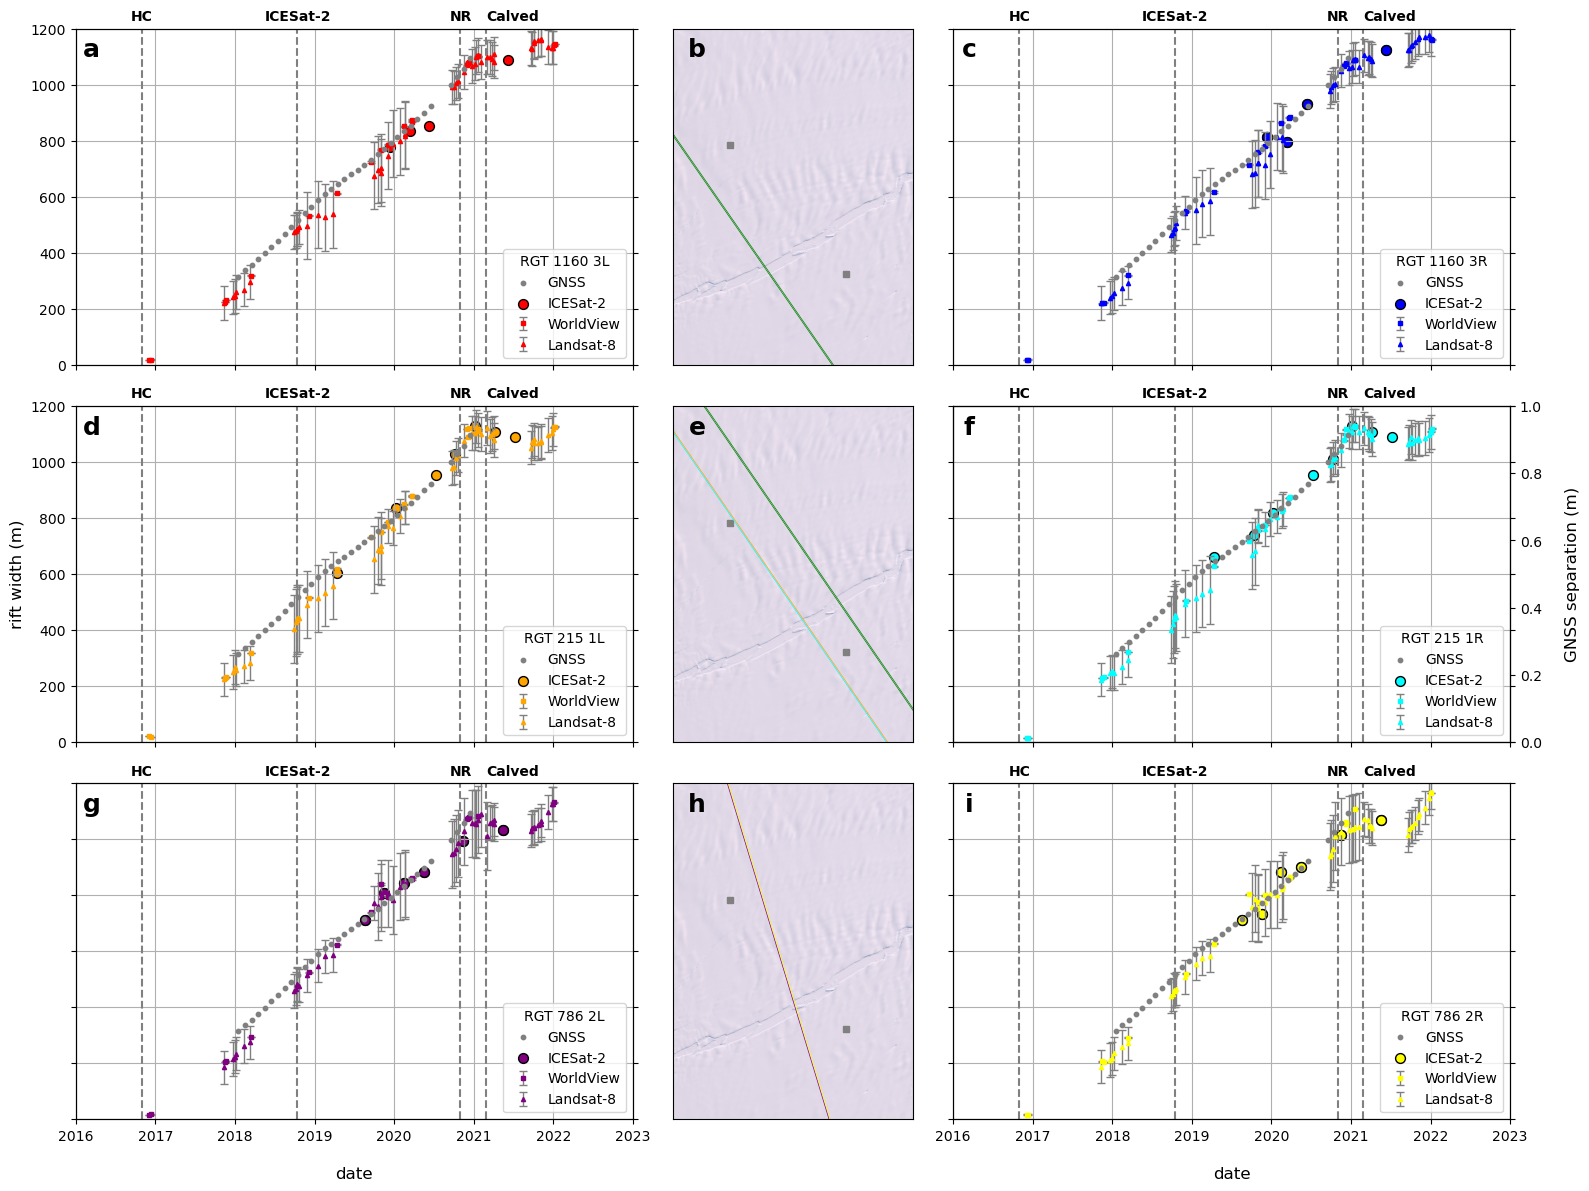

In [19]:
# Initialize figure and gridspec only once
ftsz = 10
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 5)

# Subplot 1
ax1 = plt.subplot(gs[0:1, 0:2])
plot_all_data(ax1, hh00_t, actual_hh00_tt05_sep_d_div,
              decdate_1160_3l, halloween_obs_merged_1160_3l["actual-non-iceberg-width"],
              (slice(0, 3), slice(4, 5)),
              satellite_obs_1160_WV_3l, wv_1160_3l_err,
              satellite_obs_1160_L8_3l, l8_1160_3l_err,
              'r', "RGT 1160 3L", "a")

# Subplot 2
ax2 = plt.subplot(gs[0:1, 3:5])
plot_all_data(ax2, hh00_t, actual_hh00_tt05_sep_d_div,
              decdate_1160_3r, halloween_obs_merged_1160_3r["actual-non-iceberg-width"],
              (slice(1, 5), slice(1, 5)),
              satellite_obs_1160_WV_3r, wv_1160_3r_err,
              satellite_obs_1160_L8_3r, l8_1160_3r_err,
              'b', "RGT 1160 3R", "c")
ax2.axes.yaxis.set_ticklabels([])

# Subplot 3
ax3 = plt.subplot(gs[1:2, 0:2])
plot_all_data(ax3, hh00_t, actual_hh00_tt05_sep_d_div,
              decdate_215_1l, halloween_obs_merged_215_1l["actual-non-iceberg-width"],
              (slice(0, 1), slice(3, 9)),
              satellite_obs_215_WV_1l, wv_215_1l_err,
              satellite_obs_215_L8_1l, l8_215_1l_err,
              'orange', "RGT 215 1L", "d")
ax3.set_ylabel("rift width (m)", fontsize=ftsz+2)

# Subplot 4
ax4 = plt.subplot(gs[1:2, 3:5])
plot_all_data(ax4, hh00_t, actual_hh00_tt05_sep_d_div,
              decdate_215_1r, halloween_obs_merged_215_1r["actual-non-iceberg-width"],
              (slice(0, 1), slice(2, 9)),
              satellite_obs_215_WV_1r, wv_215_1r_err,
              satellite_obs_215_L8_1r, l8_215_1r_err,
              'cyan', "RGT 215 1R", "f")
ax4.axes.yaxis.set_ticklabels([])

# Subplot 5
ax5 = plt.subplot(gs[2:3, 0:2])
plot_all_data(ax5, hh00_t, actual_hh00_tt05_sep_d_div,
              decdate_786_2l, halloween_obs_merged_786_2l["actual-non-iceberg-width"],
              (slice(2, 8), slice(2, 8)),
              satellite_obs_786_WV_2l, wv_786_2l_err,
              satellite_obs_786_L8_2l, l8_786_2l_err,
              'purple', "RGT 786 2L", "g")
ax5.set_xlabel("\ndate", fontsize=ftsz+2)
ax5.axes.yaxis.set_ticklabels([])
ax5.axes.xaxis.set_ticklabels((2016,2017,2018,2019,2020,2021,2022,2023))

# Subplot 6
ax6 = plt.subplot(gs[2:3, 3:5])
plot_all_data(ax6, hh00_t, actual_hh00_tt05_sep_d_div,
              decdate_786_2r, halloween_obs_merged_786_2r["actual-non-iceberg-width"],
              (slice(2, 8), slice(2, 8)),
              satellite_obs_786_WV_2r, wv_786_2r_err,
              satellite_obs_786_L8_2r, l8_786_2r_err,
              'yellow', "RGT 786 2R", "i")
ax6.set_xlabel("\ndate", fontsize=ftsz+2)
ax6.axes.yaxis.set_ticklabels([])
ax6.axes.xaxis.set_ticklabels((2016,2017,2018,2019,2020,2021,2022,2023))


# Common variables for images
xmininsw = -700000
xmaxinsw = -680000
ymininsw = 1420000 
ymaxinsw = 1448000
image_data = {
    'array': norm1.transpose(2, 0, 1),
    'transform': img1_2.transform
}

# Subplot 7: Image 1
ax_pos_101 = (0, 1, 2, 3)
shapefile_data_101 = [
    {'shapefile': shapefile1L_ar, 'index': 190, 'color': 'g'},
    {'shapefile': shapefile1R_ar, 'index': 190, 'color': 'g'},
    {'shapefile': shapefile2L_ar, 'index': 191, 'color': 'g'},
    {'shapefile': shapefile2R_ar, 'index': 192, 'color': 'g'},
    {'shapefile': shapefile3L_ar, 'index': 176, 'color': 'r'},
    {'shapefile': shapefile3R_ar, 'index': 176, 'color': 'b'}
]
create_image_subplot(ax_pos_101, gs, image_data,
                     shapefile_data_101, "b")

# Subplot 8: Image 2
ax_pos_102 = (1, 2, 2, 3)
shapefile_data_102 = [
    {'shapefile': shapefile1L_ar, 'index': 34, 'color': 'orange'},
    {'shapefile': shapefile1R_ar, 'index': 34, 'color': 'cyan'},
    {'shapefile': shapefile2L_ar, 'index': 34, 'color': 'g'},
    {'shapefile': shapefile2R_ar, 'index': 34, 'color': 'g'},
    {'shapefile': shapefile3L_ar, 'index': 32, 'color': 'g'},
    {'shapefile': shapefile3R_ar, 'index': 32, 'color': 'g'}
]
create_image_subplot(ax_pos_102, gs, image_data,
                     shapefile_data_102, "e")

# Subplot 9: Image 3
ax_pos_103 = (2, 3, 2, 3)
shapefile_data_103 = [
    {'shapefile': shapefile1L_ar, 'index': 129, 'color': 'g'},
    {'shapefile': shapefile1R_ar, 'index': 129, 'color': 'g'},
    {'shapefile': shapefile2L_ar, 'index': 129, 'color': 'purple'},
    {'shapefile': shapefile2R_ar, 'index': 130, 'color': 'yellow'},
    {'shapefile': shapefile3L_ar, 'index': 119, 'color': 'g'},
    {'shapefile': shapefile3R_ar, 'index': 119, 'color': 'g'}
]
create_image_subplot(ax_pos_103, gs, image_data,
                     shapefile_data_103, "h")

# Adjust labels and save the figure
ax3.set_ylabel("rift width (m)", fontsize=ftsz+2)
ax4_twin = ax4.twinx()
ax4_twin.set_ylabel("\nGNSS separation (m)", fontsize=ftsz+2)
ax5.set_xlabel("\ndate", fontsize=ftsz+2)
ax6.set_xlabel("\ndate", fontsize=ftsz+2)

plt.tight_layout()
output = figure_folder + '/fig04_western_map_graph.png'
plt.savefig(output, dpi=100, bbox_inches='tight')
plt.show()

## Figure 4 along 283 1LR, 725 3LR, 1099 2LR
Graph of comparison between GPS, ICESat-2, Landsat-8, WorldView

### subset detections

In [20]:
halloween_obs_merged_283_1l = halloween_obs_merged[(halloween_obs_merged["rgt"]==283) & (halloween_obs_merged["beam"]=='1l')]
halloween_obs_merged_283_1r = halloween_obs_merged[(halloween_obs_merged["rgt"]==283) & (halloween_obs_merged["beam"]=='1r')]

halloween_obs_merged_283_1l = gpd.GeoDataFrame(
    halloween_obs_merged_283_1l, geometry=gpd.points_from_xy(halloween_obs_merged_283_1l['x-centroid'], halloween_obs_merged_283_1l['y-centroid']))
halloween_obs_merged_283_1r = gpd.GeoDataFrame(
    halloween_obs_merged_283_1r, geometry=gpd.points_from_xy(halloween_obs_merged_283_1r['x-centroid'], halloween_obs_merged_283_1r['y-centroid']))
    
#display(halloween_obs_merged_283_1l)
#display(halloween_obs_merged_283_1r)

halloween_obs_merged_725_3l = halloween_obs_merged[(halloween_obs_merged["rgt"]==725) & (halloween_obs_merged["beam"]=='3l')]
halloween_obs_merged_725_3r = halloween_obs_merged[(halloween_obs_merged["rgt"]==725) & (halloween_obs_merged["beam"]=='3r')]

halloween_obs_merged_725_3l = gpd.GeoDataFrame(
    halloween_obs_merged_725_3l, geometry=gpd.points_from_xy(halloween_obs_merged_725_3l['x-centroid'], halloween_obs_merged_725_3l['y-centroid']))
halloween_obs_merged_725_3r = gpd.GeoDataFrame(
    halloween_obs_merged_725_3r, geometry=gpd.points_from_xy(halloween_obs_merged_725_3r['x-centroid'], halloween_obs_merged_725_3r['y-centroid']))

#display(halloween_obs_merged_725_3l)
#display(halloween_obs_merged_725_3r)

halloween_obs_merged_1099_2l = halloween_obs_merged[(halloween_obs_merged["rgt"]==1099) & (halloween_obs_merged["beam"]=='2l')]
halloween_obs_merged_1099_2r = halloween_obs_merged[(halloween_obs_merged["rgt"]==1099) & (halloween_obs_merged["beam"]=='2r')]

halloween_obs_merged_1099_2l = gpd.GeoDataFrame(
    halloween_obs_merged_1099_2l, geometry=gpd.points_from_xy(halloween_obs_merged_1099_2l['x-centroid'], halloween_obs_merged_1099_2l['y-centroid']))
halloween_obs_merged_1099_2r = gpd.GeoDataFrame(
    halloween_obs_merged_1099_2r, geometry=gpd.points_from_xy(halloween_obs_merged_1099_2r['x-centroid'], halloween_obs_merged_1099_2r['y-centroid']))
    
#display(halloween_obs_merged_1099_2l)
#display(halloween_obs_merged_1099_2r)


### rotate to rift coordinates

In [21]:
azimuth_283_1l = []

for index, row in halloween_obs_merged_283_1l.iterrows():
    azimuth_283_1l.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_283_1l = np.abs(np.sin(np.deg2rad(azimuth_283_1l - halloween_obs_merged_283_1l['azimuth']))) * halloween_obs_merged_283_1l['width']
actual_non_iceberg_width_283_1l = np.abs(np.sin(np.deg2rad(azimuth_283_1l - halloween_obs_merged_283_1l['azimuth']))) * halloween_obs_merged_283_1l['non-iceberg-width']

azimuth_283_1r = []

for index, row in halloween_obs_merged_283_1r.iterrows():    
    azimuth_283_1r.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_283_1r = np.abs(np.sin(np.deg2rad(azimuth_283_1r - halloween_obs_merged_283_1r['azimuth']))) * halloween_obs_merged_283_1r['width']
actual_non_iceberg_width_283_1r = np.abs(np.sin(np.deg2rad(azimuth_283_1r - halloween_obs_merged_283_1r['azimuth']))) * halloween_obs_merged_283_1r['non-iceberg-width']

azimuth_725_3l = []

for index, row in halloween_obs_merged_725_3l.iterrows():
    azimuth_725_3l.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_725_3l = np.abs(np.sin(np.deg2rad(azimuth_725_3l - halloween_obs_merged_725_3l['azimuth']))) * halloween_obs_merged_725_3l['width']
actual_non_iceberg_width_725_3l = np.abs(np.sin(np.deg2rad(azimuth_725_3l - halloween_obs_merged_725_3l['azimuth']))) * halloween_obs_merged_725_3l['non-iceberg-width']

azimuth_725_3r = []

for index, row in halloween_obs_merged_725_3r.iterrows():    
    azimuth_725_3r.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_725_3r = np.abs(np.sin(np.deg2rad(azimuth_725_3r - halloween_obs_merged_725_3r['azimuth']))) * halloween_obs_merged_725_3r['width']
actual_non_iceberg_width_725_3r = np.abs(np.sin(np.deg2rad(azimuth_725_3r - halloween_obs_merged_725_3r['azimuth']))) * halloween_obs_merged_725_3r['non-iceberg-width']

azimuth_1099_2l = []

for index, row in halloween_obs_merged_1099_2l.iterrows():
    azimuth_1099_2l.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_1099_2l = np.abs(np.sin(np.deg2rad(azimuth_1099_2l - halloween_obs_merged_1099_2l['azimuth']))) * halloween_obs_merged_1099_2l['width']
actual_non_iceberg_width_1099_2l = np.abs(np.sin(np.deg2rad(azimuth_1099_2l - halloween_obs_merged_1099_2l['azimuth']))) * halloween_obs_merged_1099_2l['non-iceberg-width']

azimuth_1099_2r = []

for index, row in halloween_obs_merged_1099_2r.iterrows():    
    azimuth_1099_2r.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_1099_2r = np.abs(np.sin(np.deg2rad(azimuth_1099_2r - halloween_obs_merged_1099_2r['azimuth']))) * halloween_obs_merged_1099_2r['width']
actual_non_iceberg_width_1099_2r = np.abs(np.sin(np.deg2rad(azimuth_1099_2r - halloween_obs_merged_1099_2r['azimuth']))) * halloween_obs_merged_1099_2r['non-iceberg-width']


halloween_obs_merged_283_1l['rift-angle'] = pd.Series(np.array(azimuth_283_1l), index=halloween_obs_merged_283_1l.index)
halloween_obs_merged_283_1r['rift-angle'] = pd.Series(np.array(azimuth_283_1r), index=halloween_obs_merged_283_1r.index)
halloween_obs_merged_283_1l["actual-width"] = pd.Series(np.array(actual_width_283_1l), index=halloween_obs_merged_283_1l.index)
halloween_obs_merged_283_1r["actual-width"] = pd.Series(np.array(actual_width_283_1r), index=halloween_obs_merged_283_1r.index)
halloween_obs_merged_283_1l["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_283_1l), index=halloween_obs_merged_283_1l.index)
halloween_obs_merged_283_1r["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_283_1r), index=halloween_obs_merged_283_1r.index)

#display(halloween_obs_merged_283_1l)
#display(halloween_obs_merged_283_1r)

halloween_obs_merged_725_3l['rift-angle'] = pd.Series(np.array(azimuth_725_3l), index=halloween_obs_merged_725_3l.index)
halloween_obs_merged_725_3r['rift-angle'] = pd.Series(np.array(azimuth_725_3r), index=halloween_obs_merged_725_3r.index)
halloween_obs_merged_725_3l["actual-width"] = pd.Series(np.array(actual_width_725_3l), index=halloween_obs_merged_725_3l.index)
halloween_obs_merged_725_3r["actual-width"] = pd.Series(np.array(actual_width_725_3r), index=halloween_obs_merged_725_3r.index)
halloween_obs_merged_725_3l["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_725_3l), index=halloween_obs_merged_725_3l.index)
halloween_obs_merged_725_3r["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_725_3r), index=halloween_obs_merged_725_3r.index)

#display(halloween_obs_merged_725_3l)
#display(halloween_obs_merged_725_3r)

halloween_obs_merged_1099_2l['rift-angle'] = pd.Series(np.array(azimuth_1099_2l), index=halloween_obs_merged_1099_2l.index)
halloween_obs_merged_1099_2r['rift-angle'] = pd.Series(np.array(azimuth_1099_2r), index=halloween_obs_merged_1099_2r.index)
halloween_obs_merged_1099_2l["actual-width"] = pd.Series(np.array(actual_width_1099_2l), index=halloween_obs_merged_1099_2l.index)
halloween_obs_merged_1099_2r["actual-width"] = pd.Series(np.array(actual_width_1099_2r), index=halloween_obs_merged_1099_2r.index)
halloween_obs_merged_1099_2l["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_1099_2l), index=halloween_obs_merged_1099_2l.index)
halloween_obs_merged_1099_2r["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_1099_2r), index=halloween_obs_merged_1099_2r.index)

#display(halloween_obs_merged_1099_2l)
#display(halloween_obs_merged_1099_2r)


### calculate decimal times

In [22]:
num_283_1l = [1,217,268,356,406]
num_283_1r = [4,220,271,357,409]

num_725_3l = [19,90,331,366]
num_725_3r = [22,93,334,369]

num_1099_2l = [54,152,194,290]
num_1099_2r = [57,155,197,293]

time_283_1l = halloween_obs_merged_283_1l["time"]
time_283_1r = halloween_obs_merged_283_1r["time"]

year_283_1l = []
month_283_1l = []
day_283_1l = []
year_283_1r = []
month_283_1r = []
day_283_1r = []

time_725_3l = halloween_obs_merged_725_3l["time"]
time_725_3r = halloween_obs_merged_725_3r["time"]

year_725_3l = []
month_725_3l = []
day_725_3l = []
year_725_3r = []
month_725_3r = []
day_725_3r = []

time_1099_2l = halloween_obs_merged_1099_2l["time"]
time_1099_2r = halloween_obs_merged_1099_2r["time"]

year_1099_2l = []
month_1099_2l = []
day_1099_2l = []
year_1099_2r = []
month_1099_2r = []
day_1099_2r = []


for tl in range(0,len(time_283_1l)):
    year_283_1l.append(int(str(time_283_1l[num_283_1l[tl]].date())[0:4]))
    month_283_1l.append(int(str(time_283_1l[num_283_1l[tl]].date())[5:7]))
    day_283_1l.append(int(str(time_283_1l[num_283_1l[tl]].date())[8:10]))

for tr in range(0,len(time_283_1r)):
    year_283_1r.append(int(str(time_283_1r[num_283_1r[tr]].date())[0:4]))
    month_283_1r.append(int(str(time_283_1r[num_283_1r[tr]].date())[5:7]))
    day_283_1r.append(int(str(time_283_1r[num_283_1r[tr]].date())[8:10]))

decdate_283_1l = np.array(year_283_1l) + ((np.array(month_283_1l)-1) / 12) + ((np.array(day_283_1l)-1) / 365)
decdate_283_1r = np.array(year_283_1r) + ((np.array(month_283_1r)-1) / 12) + ((np.array(day_283_1r)-1) / 365)

for tl2 in range(0,len(time_725_3l)):
    year_725_3l.append(int(str(time_725_3l[num_725_3l[tl2]].date())[0:4]))
    month_725_3l.append(int(str(time_725_3l[num_725_3l[tl2]].date())[5:7]))
    day_725_3l.append(int(str(time_725_3l[num_725_3l[tl2]].date())[8:10]))

for tr2 in range(0,len(time_725_3r)):
    year_725_3r.append(int(str(time_725_3r[num_725_3r[tr2]].date())[0:4]))
    month_725_3r.append(int(str(time_725_3r[num_725_3r[tr2]].date())[5:7]))
    day_725_3r.append(int(str(time_725_3r[num_725_3r[tr2]].date())[8:10]))

decdate_725_3l = np.array(year_725_3l) + ((np.array(month_725_3l)-1) / 12) + ((np.array(day_725_3l)-1) / 365)
decdate_725_3r = np.array(year_725_3r) + ((np.array(month_725_3r)-1) / 12) + ((np.array(day_725_3r)-1) / 365)

for tl in range(0,len(time_1099_2l)):
    year_1099_2l.append(int(str(time_1099_2l[num_1099_2l[tl]].date())[0:4]))
    month_1099_2l.append(int(str(time_1099_2l[num_1099_2l[tl]].date())[5:7]))
    day_1099_2l.append(int(str(time_1099_2l[num_1099_2l[tl]].date())[8:10]))

for tr in range(0,len(time_1099_2r)):
    year_1099_2r.append(int(str(time_1099_2r[num_1099_2r[tr]].date())[0:4]))
    month_1099_2r.append(int(str(time_1099_2r[num_1099_2r[tr]].date())[5:7]))
    day_1099_2r.append(int(str(time_1099_2r[num_1099_2r[tr]].date())[8:10]))

decdate_1099_2l = np.array(year_1099_2l) + ((np.array(month_1099_2l)-1) / 12) + ((np.array(day_1099_2l)-1) / 365)
decdate_1099_2r = np.array(year_1099_2r) + ((np.array(month_1099_2r)-1) / 12) + ((np.array(day_1099_2r)-1) / 365)



In [23]:
# calculate the decimal date
decimal_date = []
Ecentroid = []
Ncentroid = []
for index, row in satellite_obs_283.iterrows():
    decimal_date.append(row["year"]+((row["month"]-1)/12)+((row["day"]-1)/365))
    [Ecent,Ncent] = transformer_latlon2ps.transform(row["centroid_lat"],row["centroid_lon"])
    Ecentroid.append(Ecent)
    Ncentroid.append(Ncent)
    
satellite_obs_283["decimal_date"] = decimal_date
satellite_obs_283["x-centroid"] = Ecentroid
satellite_obs_283["y-centroid"] = Ncentroid

satellite_obs_283 = gpd.GeoDataFrame(satellite_obs_283, geometry=gpd.points_from_xy(satellite_obs_283["x-centroid"],satellite_obs_283["y-centroid"]))

# calculate the actual width
azimuth = []

for index, row in satellite_obs_283.iterrows():
    azimuth.append(estimate_local_rift_orientation_new(row["geometry"],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_283['azimuth']))) * satellite_obs_283['total_width']
actual_non_iceberg_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_283['azimuth']))) * satellite_obs_283['non-iceberg_width']

satellite_obs_283['rift-angle'] = pd.Series(np.array(azimuth), index=satellite_obs_283.index)
satellite_obs_283['actual-width'] = pd.Series(np.array(actual_width), index=satellite_obs_283.index)
satellite_obs_283['actual-non-iceberg-width'] = pd.Series(np.array(actual_non_iceberg_width), index=satellite_obs_283.index)

satellite_obs_283_WV_1l = satellite_obs_283[(satellite_obs_283["platform"]=="WV") & (satellite_obs_283["laser"]=="1l")]
satellite_obs_283_WV_1r = satellite_obs_283[(satellite_obs_283["platform"]=="WV") & (satellite_obs_283["laser"]=="1r")]
satellite_obs_283_L8_1l = satellite_obs_283[(satellite_obs_283["platform"]=="L8") & (satellite_obs_283["laser"]=="1l")]
satellite_obs_283_L8_1r = satellite_obs_283[(satellite_obs_283["platform"]=="L8") & (satellite_obs_283["laser"]=="1r")]

#display(satellite_obs_283)
#display(satellite_obs_283_WV_1l)
#display(satellite_obs_283_WV_1r)
#display(satellite_obs_283_L8_1l)
#display(satellite_obs_283_L8_1r)


In [24]:


# calculate the decimal date
decimal_date = []
Ecentroid = []
Ncentroid = []
for index, row in satellite_obs_725.iterrows():
    decimal_date.append(row["year"]+((row["month"]-1)/12)+((row["day"]-1)/365))
    [Ecent,Ncent] = transformer_latlon2ps.transform(row["centroid_lat"],row["centroid_lon"])
    Ecentroid.append(Ecent)
    Ncentroid.append(Ncent)
    
satellite_obs_725["decimal_date"] = decimal_date
satellite_obs_725["x-centroid"] = Ecentroid
satellite_obs_725["y-centroid"] = Ncentroid

satellite_obs_725 = gpd.GeoDataFrame(satellite_obs_725, geometry=gpd.points_from_xy(satellite_obs_725["x-centroid"],satellite_obs_725["y-centroid"]))

# calculate the actual width
azimuth = []

for index, row in satellite_obs_725.iterrows():
    azimuth.append(estimate_local_rift_orientation_new(row["geometry"],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_725['azimuth']))) * satellite_obs_725['total_width']
actual_non_iceberg_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_725['azimuth']))) * satellite_obs_725['non-iceberg_width']

satellite_obs_725['rift-angle'] = pd.Series(np.array(azimuth), index=satellite_obs_725.index)
satellite_obs_725['actual-width'] = pd.Series(np.array(actual_width), index=satellite_obs_725.index)
satellite_obs_725['actual-non-iceberg-width'] = pd.Series(np.array(actual_non_iceberg_width), index=satellite_obs_725.index)

satellite_obs_725_WV_3l = satellite_obs_725[(satellite_obs_725["platform"]=="WV") & (satellite_obs_725["laser"]=="3l")]
satellite_obs_725_WV_3r = satellite_obs_725[(satellite_obs_725["platform"]=="WV") & (satellite_obs_725["laser"]=="3r")]
satellite_obs_725_L8_3l = satellite_obs_725[(satellite_obs_725["platform"]=="L8") & (satellite_obs_725["laser"]=="3l")]
satellite_obs_725_L8_3r = satellite_obs_725[(satellite_obs_725["platform"]=="L8") & (satellite_obs_725["laser"]=="3r")]

#display(satellite_obs_725)
#display(satellite_obs_725_WV_3l)
#display(satellite_obs_725_WV_3r)
#display(satellite_obs_725_L8_3l)
#display(satellite_obs_725_L8_3r)


In [25]:


# calculate the decimal date
decimal_date = []
Ecentroid = []
Ncentroid = []
for index, row in satellite_obs_1099.iterrows():
    decimal_date.append(row["year"]+((row["month"]-1)/12)+((row["day"]-1)/365))
    [Ecent,Ncent] = transformer_latlon2ps.transform(row["centroid_lat"],row["centroid_lon"])
    Ecentroid.append(Ecent)
    Ncentroid.append(Ncent)
    
satellite_obs_1099["decimal_date"] = decimal_date
satellite_obs_1099["x-centroid"] = Ecentroid
satellite_obs_1099["y-centroid"] = Ncentroid

satellite_obs_1099 = gpd.GeoDataFrame(satellite_obs_1099, geometry=gpd.points_from_xy(satellite_obs_1099["x-centroid"],satellite_obs_1099["y-centroid"]))

# calculate the actual width
azimuth = []

for index, row in satellite_obs_1099.iterrows():
    azimuth.append(estimate_local_rift_orientation_new(row["geometry"],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_1099['azimuth']))) * satellite_obs_1099['total_width']
actual_non_iceberg_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_1099['azimuth']))) * satellite_obs_1099['non-iceberg_width']

satellite_obs_1099['rift-angle'] = pd.Series(np.array(azimuth), index=satellite_obs_1099.index)
satellite_obs_1099['actual-width'] = pd.Series(np.array(actual_width), index=satellite_obs_1099.index)
satellite_obs_1099['actual-non-iceberg-width'] = pd.Series(np.array(actual_non_iceberg_width), index=satellite_obs_1099.index)

satellite_obs_1099_WV_2l = satellite_obs_1099[(satellite_obs_1099["platform"]=="WV") & (satellite_obs_1099["laser"]=="2l")]
satellite_obs_1099_WV_2r = satellite_obs_1099[(satellite_obs_1099["platform"]=="WV") & (satellite_obs_1099["laser"]=="2r")]
satellite_obs_1099_L8_2l = satellite_obs_1099[(satellite_obs_1099["platform"]=="L8") & (satellite_obs_1099["laser"]=="2l")]
satellite_obs_1099_L8_2r = satellite_obs_1099[(satellite_obs_1099["platform"]=="L8") & (satellite_obs_1099["laser"]=="2r")]

#display(satellite_obs_1099)
#display(satellite_obs_1099_WV_2l)
#display(satellite_obs_1099_WV_2r)
#display(satellite_obs_1099_L8_2l)
#display(satellite_obs_1099_L8_2r)


### error bars

In [26]:
# error bars
l8_pix = 30 # m rgb pixels
wv_pix  = 0.5 # m approx pixels
nr_pix  = 2 # number of pixels each side

l8_283_1l_err = []
l8_283_1r_err = []
wv_283_1l_err = []
wv_283_1r_err = []
l8_725_3l_err = []
l8_725_3r_err = []
wv_725_3l_err = []
wv_725_3r_err = []
l8_1099_2l_err = []
l8_1099_2r_err = []
wv_1099_2l_err = []
wv_1099_2r_err = []

# double sized error bars where iceberg/peninsula/bridge within rift

#283
for ii in range (0,len(satellite_obs_283_WV_1l["total_width"])):
    if (satellite_obs_283_WV_1l["total_width"].iloc[ii] == satellite_obs_283_WV_1l["non-iceberg_width"].iloc[ii]):
        wv_283_1l_err.append(1*wv_pix*nr_pix)
    else:
        wv_283_1l_err.append(2*wv_pix*nr_pix)
        
for ij in range (0,len(satellite_obs_283_WV_1r["total_width"])):
    if (satellite_obs_283_WV_1r["total_width"].iloc[ij] == satellite_obs_283_WV_1r["non-iceberg_width"].iloc[ij]):
        wv_283_1r_err.append(1*wv_pix*nr_pix)
    else:
        wv_283_1r_err.append(2*wv_pix*nr_pix)
        
for ik in range (0,len(satellite_obs_283_L8_1l["total_width"])):
    if (satellite_obs_283_L8_1l["total_width"].iloc[ik] == satellite_obs_283_L8_1l["non-iceberg_width"].iloc[ik]):
        l8_283_1l_err.append(1*l8_pix*nr_pix)
    else:
        l8_283_1l_err.append(2*l8_pix*nr_pix)
        
for il in range (0,len(satellite_obs_283_L8_1r["total_width"])):
    if (satellite_obs_283_L8_1r["total_width"].iloc[il] == satellite_obs_283_L8_1r["non-iceberg_width"].iloc[il]):
        l8_283_1r_err.append(1*l8_pix*nr_pix)
    else:
        l8_283_1r_err.append(2*l8_pix*nr_pix)

#725
for ji in range (0,len(satellite_obs_725_WV_3l["total_width"])):
    if (satellite_obs_725_WV_3l["total_width"].iloc[ji] == satellite_obs_725_WV_3l["non-iceberg_width"].iloc[ji]):
        wv_725_3l_err.append(1*wv_pix*nr_pix)
    else:
        wv_725_3l_err.append(2*wv_pix*nr_pix)
        
for jj in range (0,len(satellite_obs_725_WV_3r["total_width"])):
    if (satellite_obs_725_WV_3r["total_width"].iloc[jj] == satellite_obs_725_WV_3r["non-iceberg_width"].iloc[jj]):
        wv_725_3r_err.append(1*wv_pix*nr_pix)
    else:
        wv_725_3r_err.append(2*wv_pix*nr_pix)
        
for jk in range (0,len(satellite_obs_725_L8_3l["total_width"])):
    if (satellite_obs_725_L8_3l["total_width"].iloc[jk] == satellite_obs_725_L8_3l["non-iceberg_width"].iloc[jk]):
        l8_725_3l_err.append(1*l8_pix*nr_pix)
    else:
        l8_725_3l_err.append(2*l8_pix*nr_pix)
        
for jl in range (0,len(satellite_obs_725_L8_3r["total_width"])):
    if (satellite_obs_725_L8_3r["total_width"].iloc[jl] == satellite_obs_725_L8_3r["non-iceberg_width"].iloc[jl]):
        l8_725_3r_err.append(1*l8_pix*nr_pix)
    else:
        l8_725_3r_err.append(2*l8_pix*nr_pix)
        
#1099
for ii in range (0,len(satellite_obs_1099_WV_2l["total_width"])):
    if (satellite_obs_1099_WV_2l["total_width"].iloc[ii] == satellite_obs_1099_WV_2l["non-iceberg_width"].iloc[ii]):
        wv_1099_2l_err.append(1*wv_pix*nr_pix)
    else:
        wv_1099_2l_err.append(2*wv_pix*nr_pix)
        
for ij in range (0,len(satellite_obs_1099_WV_2r["total_width"])):
    if (satellite_obs_1099_WV_2r["total_width"].iloc[ij] == satellite_obs_1099_WV_2r["non-iceberg_width"].iloc[ij]):
        wv_1099_2r_err.append(1*wv_pix*nr_pix)
    else:
        wv_1099_2r_err.append(2*wv_pix*nr_pix)
        
for ik in range (0,len(satellite_obs_1099_L8_2l["total_width"])):
    if (satellite_obs_1099_L8_2l["total_width"].iloc[ik] == satellite_obs_1099_L8_2l["non-iceberg_width"].iloc[ik]):
        l8_1099_2l_err.append(1*l8_pix*nr_pix)
    else:
        l8_1099_2l_err.append(2*l8_pix*nr_pix)
        
for il in range (0,len(satellite_obs_1099_L8_2r["total_width"])):
    if (satellite_obs_1099_L8_2r["total_width"].iloc[il] == satellite_obs_1099_L8_2r["non-iceberg_width"].iloc[il]):
        l8_1099_2r_err.append(1*l8_pix*nr_pix)
    else:
        l8_1099_2r_err.append(2*l8_pix*nr_pix)



# Figure 7

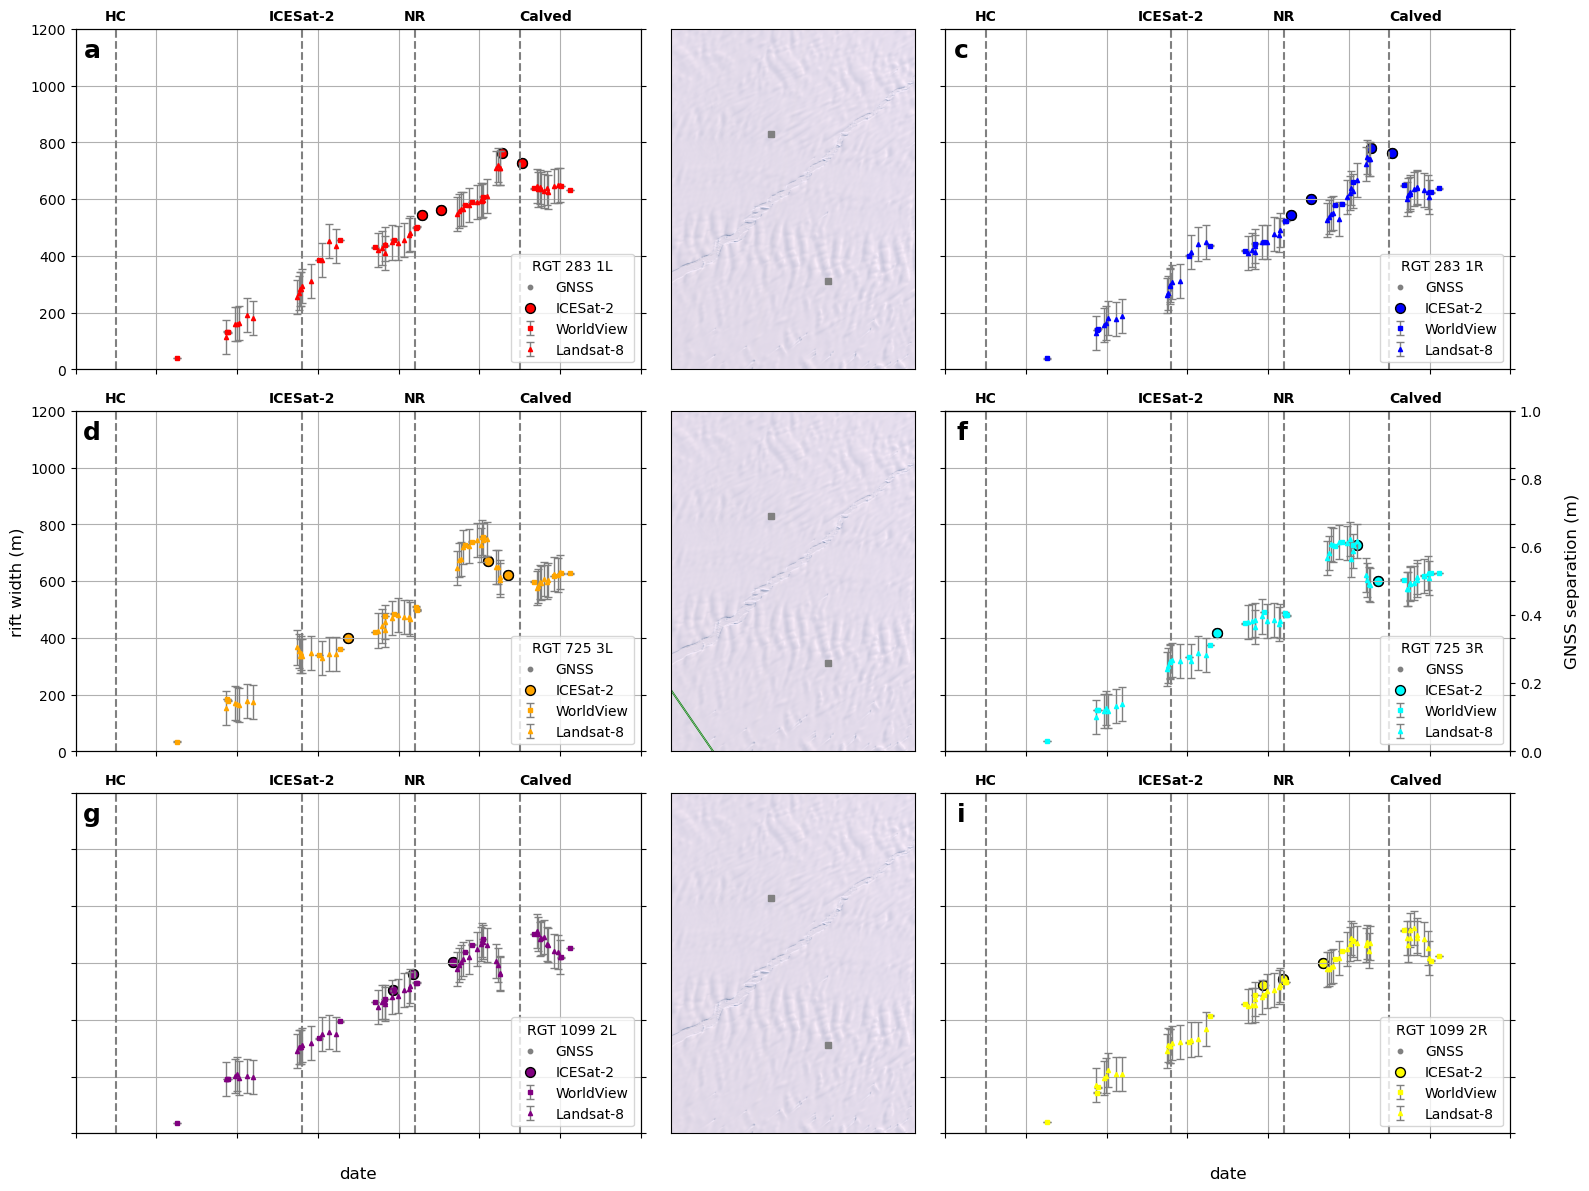

In [27]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from rasterio.plot import show

# Define required variables
ftsz = 10

# GNSS data variables
hh00_t = ss00_t
actual_hh00_tt05_sep_d_div = actual_ss00_tt04_sep_d_div

# Variables used in plot_all_data function
HC_found = 2016.5  # Replace with actual value
IS_start = 2018.8  # Replace with actual value
NR_found = 2020.2  # Replace with actual value
NR_calve = 2021.5  # Replace with actual value

# Variables used in create_image_subplot function
hh00_x = ss00_x
hh00_y = ss00_y
tt05_x = tt04_x
tt05_y = tt04_y
xmininsw = -685000
xmaxinsw = -665000
ymininsw = 1425000
ymaxinsw = 1453000

# Initialize figure and gridspec
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 5)

# Subplot 1: RGT 283 1L
ax1 = plt.subplot(gs[0:1, 0:2])
plot_all_data(
    ax1,
    hh00_t, actual_hh00_tt05_sep_d_div,
    decdate_283_1l, halloween_obs_merged_283_1l["actual-non-iceberg-width"],
    (slice(1, 5), slice(1, 5)),
    satellite_obs_283_WV_1l, wv_283_1l_err,
    satellite_obs_283_L8_1l, l8_283_1l_err,
    'r', "RGT 283 1L", "a"
)

# Subplot 2: RGT 283 1R
ax2 = plt.subplot(gs[0, 3:5])
plot_all_data(
    ax2,
    hh00_t, actual_hh00_tt05_sep_d_div,
    decdate_283_1r, halloween_obs_merged_283_1r["actual-non-iceberg-width"],
    (slice(1, 5), slice(1, 5)),
    satellite_obs_283_WV_1r, wv_283_1r_err,
    satellite_obs_283_L8_1r, l8_283_1r_err,
    'b', "RGT 283 1R", "c"
)
ax2.axes.yaxis.set_ticklabels([])

# Subplot 3: RGT 725 3L
ax3 = plt.subplot(gs[1:2, 0:2])
plot_all_data(
    ax3,
    hh00_t, actual_hh00_tt05_sep_d_div,
    decdate_725_3l, halloween_obs_merged_725_3l["actual-non-iceberg-width"],
    (slice(1, 4), slice(1, 4)),
    satellite_obs_725_WV_3l, wv_725_3l_err,
    satellite_obs_725_L8_3l, l8_725_3l_err,
    'orange', "RGT 725 3L", "d"
)
ax3.set_ylabel("rift width (m)", fontsize=ftsz + 2)

# Subplot 4: RGT 725 3R
ax4 = plt.subplot(gs[1:2, 3:5])
plot_all_data(
    ax4,
    hh00_t, actual_hh00_tt05_sep_d_div,
    decdate_725_3r, halloween_obs_merged_725_3r["actual-non-iceberg-width"],
    (slice(1, 4), slice(1, 4)),
    satellite_obs_725_WV_3r, wv_725_3r_err,
    satellite_obs_725_L8_3r, l8_725_3r_err,
    'cyan', "RGT 725 3R", "f"
)
ax4.axes.yaxis.set_ticklabels([])

# Subplot 5: RGT 1099 2L
ax5 = plt.subplot(gs[2:3, 0:2])
plot_all_data(
    ax5,
    hh00_t, actual_hh00_tt05_sep_d_div,
    decdate_1099_2l, halloween_obs_merged_1099_2l["actual-non-iceberg-width"],
    (slice(1, 4), slice(1, 4)),
    satellite_obs_1099_WV_2l, wv_1099_2l_err,
    satellite_obs_1099_L8_2l, l8_1099_2l_err,
    'purple', "RGT 1099 2L", "g"
)
ax5.set_xlabel("\ndate", fontsize=ftsz + 2)
ax5.axes.yaxis.set_ticklabels([])

# Subplot 6: RGT 1099 2R
ax6 = plt.subplot(gs[2:3, 3:5])
plot_all_data(
    ax6,
    hh00_t, actual_hh00_tt05_sep_d_div,
    decdate_1099_2r, halloween_obs_merged_1099_2r["actual-non-iceberg-width"],
    (slice(1, 4), slice(1, 4)),
    satellite_obs_1099_WV_2r, wv_1099_2r_err,
    satellite_obs_1099_L8_2r, l8_1099_2r_err,
    'yellow', "RGT 1099 2R", "i"
)
ax6.set_xlabel("\ndate", fontsize=ftsz + 2)
ax6.axes.yaxis.set_ticklabels([])

# Image data remains the same
image_data = {
    'array': norm1.transpose(2, 0, 1),
    'transform': img1_2.transform
}

# Shapefile data remains the same (shapefile_data_101, shapefile_data_102, shapefile_data_103)

# Subplot 7: Image of 283
ax_pos_101 = (0, 1, 2, 3)
create_image_subplot(
    ax_pos_101, gs, image_data, shapefile_data_101,
    "b"
)

# Subplot 8: Image of 725
ax_pos_102 = (1, 2, 2, 3)
create_image_subplot(
    ax_pos_102, gs, image_data, shapefile_data_102,
    "e"
)

# Subplot 9: Image of 1099
ax_pos_103 = (2, 3, 2, 3)
create_image_subplot(
    ax_pos_103, gs, image_data, shapefile_data_103,
    "h"
)

# Adjust labels and save the figure
ax3.set_ylabel("rift width (m)", fontsize=ftsz + 2)
ax4_twin = ax4.twinx()
ax4_twin.set_ylabel("\nGNSS separation (m)", fontsize=ftsz + 2)
ax5.set_xlabel("\ndate", fontsize=ftsz + 2)
ax6.set_xlabel("\ndate", fontsize=ftsz + 2)

plt.tight_layout()
output = figure_folder + '/fig05_eastern_map_graph.png'
plt.savefig(output, dpi=100, bbox_inches='tight')
plt.show()

## Figure 6 line of best fit
Lines of best fit along GPS, ICESat-2, Landsat-8, WorldView for all\
Divide at 2021.0

### linear regression

In [28]:
# divide time
div_t = 2021.0

# post-calving mid-time for eastern GNSS pair
mid_div = 2021 + ((7-1)/12) + ((1-1)/365)

#--------------------------------------------------
# western GNSS pair pre-calving
wgps_div_slope_PreC = linregress(hh00_t[hh00_t<div_t],actual_hh00_tt05_sep_d_div[hh00_t<div_t]).slope
wgps_div_inter_PreC = linregress(hh00_t[hh00_t<div_t],actual_hh00_tt05_sep_d_div[hh00_t<div_t]).intercept

lobf_hh00_tt05_PreC = (wgps_div_slope_PreC * hh00_t[hh00_t<div_t]) + wgps_div_inter_PreC
resid_hh00_tt05_PreC = actual_hh00_tt05_sep_d_div[hh00_t<div_t] - lobf_hh00_tt05_PreC
r2_hh00_tt05_PreC = 1 - (np.sum(resid_hh00_tt05_PreC**2)/np.sum((actual_hh00_tt05_sep_d_div[hh00_t<div_t] - np.mean(actual_hh00_tt05_sep_d_div[hh00_t<div_t]))**2))

print("GNSS west Pre-Calving. rate: "+str(round(wgps_div_slope_PreC,1))+" r^2: "+str(round(r2_hh00_tt05_PreC,3)))
print("----------")

#--------------------------------------------------
# eastern GNSS pair pre-calving
egps_div_slope_PreC = linregress(ss00_t[ss00_t<div_t],actual_ss00_tt04_sep_d_div[ss00_t<div_t]).slope
egps_div_inter_PreC = linregress(ss00_t[ss00_t<div_t],actual_ss00_tt04_sep_d_div[ss00_t<div_t]).intercept

lobf_ss00_tt04_PreC = (egps_div_slope_PreC * ss00_t[ss00_t<div_t]) + egps_div_inter_PreC
resid_ss00_tt04_PreC = actual_ss00_tt04_sep_d_div[ss00_t<div_t] - lobf_ss00_tt04_PreC
r2_ss00_tt04_PreC = 1 - (np.sum(resid_ss00_tt04_PreC**2)/np.sum((actual_ss00_tt04_sep_d_div[ss00_t<div_t] - np.mean(actual_ss00_tt04_sep_d_div[ss00_t<div_t]))**2))

print("GNSS east Pre-Calving. rate: "+str(round(egps_div_slope_PreC,1))+" r^2: "+str(round(r2_ss00_tt04_PreC,3)))
print("")

#--------------------------------------------------
# eastern GNSS pair post-calving
egps_div_slope_PostC = linregress(ss00_t[ss00_t>div_t],actual_ss00_tt04_sep_d_div[ss00_t>div_t]).slope
egps_div_inter_PostC = linregress(ss00_t[ss00_t>div_t],actual_ss00_tt04_sep_d_div[ss00_t>div_t]).intercept

lobf_ss00_tt04_PostC = (egps_div_slope_PostC * ss00_t[ss00_t>div_t]) + egps_div_inter_PostC
resid_ss00_tt04_PostC = actual_ss00_tt04_sep_d_div[ss00_t>div_t] - lobf_ss00_tt04_PostC
r2_ss00_tt04_PostC = 1 - (np.sum(resid_ss00_tt04_PostC**2)/np.sum((actual_ss00_tt04_sep_d_div[ss00_t>div_t] - np.mean(actual_ss00_tt04_sep_d_div[ss00_t>div_t]))**2))

print("GNSS east Post-Calving. rate: "+str(round(egps_div_slope_PostC,1))+" r^2: "+str(round(r2_ss00_tt04_PostC,3)))
print("")

#--------------------------------------------------
# eastern GNSS first 6 months post-calving
egps_div_slope_PostC1 = linregress(ss00_t[(ss00_t>div_t)&(ss00_t<mid_div)],actual_ss00_tt04_sep_d_div[(ss00_t>div_t)&(ss00_t<mid_div)]).slope
egps_div_inter_PostC1 = linregress(ss00_t[(ss00_t>div_t)&(ss00_t<mid_div)],actual_ss00_tt04_sep_d_div[(ss00_t>div_t)&(ss00_t<mid_div)]).intercept

lobf_ss00_tt04_PostC1 = (egps_div_slope_PostC1 * ss00_t[(ss00_t>div_t)&(ss00_t<mid_div)]) + egps_div_inter_PostC1
resid_ss00_tt04_PostC1 = actual_ss00_tt04_sep_d_div[(ss00_t>div_t)&(ss00_t<mid_div)] - lobf_ss00_tt04_PostC1
r2_ss00_tt04_PostC1 = 1 - (np.sum(resid_ss00_tt04_PostC1**2)/np.sum((actual_ss00_tt04_sep_d_div[(ss00_t>div_t)&(ss00_t<mid_div)] - np.mean(actual_ss00_tt04_sep_d_div[(ss00_t>div_t)&(ss00_t<mid_div)]))**2))

print("GNSS east PostC 1st 6 months. rate: "+str(round(egps_div_slope_PostC1,1))+" r^2: "+str(round(r2_ss00_tt04_PostC1,3)))
print("")

#--------------------------------------------------
# eastern GNSS second 6 months post-calving
egps_div_slope_PostC2 = linregress(ss00_t[ss00_t>mid_div],actual_ss00_tt04_sep_d_div[ss00_t>mid_div]).slope
egps_div_inter_PostC2 = linregress(ss00_t[ss00_t>mid_div],actual_ss00_tt04_sep_d_div[ss00_t>mid_div]).intercept

lobf_ss00_tt04_PostC2 = (egps_div_slope_PostC2 * ss00_t[ss00_t>mid_div]) + egps_div_inter_PostC2
resid_ss00_tt04_PostC2 = actual_ss00_tt04_sep_d_div[ss00_t>mid_div] - lobf_ss00_tt04_PostC2
r2_ss00_tt04_PostC2 = 1 - (np.sum(resid_ss00_tt04_PostC2**2)/np.sum((actual_ss00_tt04_sep_d_div[ss00_t>mid_div] - np.mean(actual_ss00_tt04_sep_d_div[ss00_t>mid_div]))**2))

print("GNSS east PostC 2nd 6 months. rate: "+str(round(egps_div_slope_PostC2,1))+" r^2: "+str(round(r2_ss00_tt04_PostC2,3)))
print("----------")

#--------------------------------------------------
#ICESat-2 remove pointing errors
decdate_sub_1160_3l=decdate_1160_3l[[0,1,2,4]]
decdate_sub_1160_3r=decdate_1160_3r[[1,2,3,4]]
decdate_sub_215_1l=decdate_215_1l[[0,3,4,5,6,7,8]]
decdate_sub_215_1r=decdate_215_1r[[0,2,3,4,5,6,7,8]]
decdate_sub_786_2l=decdate_786_2l[[2,3,4,5,6,7]]
decdate_sub_786_2r=decdate_786_2r[[2,3,4,5,6,7]]
decdate_sub_is2_west=np.concatenate((decdate_sub_1160_3l,decdate_sub_1160_3r,decdate_sub_215_1l,decdate_sub_215_1r,decdate_sub_786_2l,decdate_sub_786_2r),axis=0)

width_1160_3l=halloween_obs_merged_1160_3l["actual-non-iceberg-width"].iloc[[0,1,2,4]]
width_1160_3r=halloween_obs_merged_1160_3r["actual-non-iceberg-width"].iloc[[1,2,3,4]]
width_215_1l=halloween_obs_merged_215_1l["actual-non-iceberg-width"].iloc[[0,3,4,5,6,7,8]]
width_215_1r=halloween_obs_merged_215_1r["actual-non-iceberg-width"].iloc[[0,2,3,4,5,6,7,8]]
width_786_2l=halloween_obs_merged_786_2l["actual-non-iceberg-width"].iloc[[2,3,4,5,6,7]]
width_786_2r=halloween_obs_merged_786_2r["actual-non-iceberg-width"].iloc[[2,3,4,5,6,7]]
width_is2_west=np.concatenate((width_1160_3l,width_1160_3r,width_215_1l,width_215_1r,width_786_2l,width_786_2r),axis=0)

decdate_sub_283_1l=decdate_283_1l[[1,2,3,4]]
decdate_sub_283_1r=decdate_283_1r[[1,2,3,4]]
decdate_sub_725_3l=decdate_725_3l[[1,2,3]]
decdate_sub_725_3r=decdate_725_3r[[1,2,3]]
decdate_sub_1099_2l=decdate_1099_2l[[1,2,3]]
decdate_sub_1099_2r=decdate_1099_2r[[1,2,3]]
decdate_sub_is2_east=np.concatenate((decdate_sub_283_1l,decdate_sub_283_1r,decdate_sub_725_3l,decdate_sub_725_3r,decdate_sub_1099_2l,decdate_sub_1099_2r),axis=0)

width_283_1l=halloween_obs_merged_283_1l["actual-non-iceberg-width"].iloc[[1,2,3,4]]
width_283_1r=halloween_obs_merged_283_1r["actual-non-iceberg-width"].iloc[[1,2,3,4]]
width_725_3l=halloween_obs_merged_725_3l["actual-non-iceberg-width"].iloc[[1,2,3]]
width_725_3r=halloween_obs_merged_725_3r["actual-non-iceberg-width"].iloc[[1,2,3]]
width_1099_2l=halloween_obs_merged_1099_2l["actual-non-iceberg-width"].iloc[[1,2,3]]
width_1099_2r=halloween_obs_merged_1099_2r["actual-non-iceberg-width"].iloc[[1,2,3]]
width_is2_east=np.concatenate((width_283_1l,width_283_1r,width_725_3l,width_725_3r,width_1099_2l,width_1099_2r),axis=0)

#--------------------------------------------------
# west ICESat-2 pre-calving
wis2_slope_PreC = linregress(decdate_sub_is2_west[decdate_sub_is2_west<div_t],width_is2_west[decdate_sub_is2_west<div_t]).slope
wis2_inter_PreC = linregress(decdate_sub_is2_west[decdate_sub_is2_west<div_t],width_is2_west[decdate_sub_is2_west<div_t]).intercept

lobf_wis2_PreC = (wis2_slope_PreC * decdate_sub_is2_west[decdate_sub_is2_west<div_t]) + wis2_inter_PreC
resid_wis2_PreC = width_is2_west[decdate_sub_is2_west<div_t] - lobf_wis2_PreC
r2_wis2_PreC = 1 - (np.sum(resid_wis2_PreC**2)/np.sum((width_is2_west[decdate_sub_is2_west<div_t] - np.mean(width_is2_west[decdate_sub_is2_west<div_t]))**2))

print("IS2 west Pre-Calving. rate: "+str(round(wis2_slope_PreC,1))+" r^2: "+str(round(r2_wis2_PreC,3)))
print("")

#--------------------------------------------------
# west ICESat-2 post-calving
wis2_slope_PostC = linregress(decdate_sub_is2_west[decdate_sub_is2_west>div_t],width_is2_west[decdate_sub_is2_west>div_t]).slope
wis2_inter_PostC = linregress(decdate_sub_is2_west[decdate_sub_is2_west>div_t],width_is2_west[decdate_sub_is2_west>div_t]).intercept

lobf_wis2_PostC = (wis2_slope_PostC * decdate_sub_is2_west[decdate_sub_is2_west>div_t]) + wis2_inter_PostC
resid_wis2_PostC = width_is2_west[decdate_sub_is2_west>div_t] - lobf_wis2_PostC
r2_wis2_PostC = 1 - (np.sum(resid_wis2_PostC**2)/np.sum((width_is2_west[decdate_sub_is2_west>div_t] - np.mean(width_is2_west[decdate_sub_is2_west>div_t]))**2))

print("IS2 west Post-Calving. rate:"+str(round(wis2_slope_PostC,1))+" r^2: "+str(round(r2_wis2_PostC,3)))
print("----------")

#--------------------------------------------------
# east ICESat-2 pre-calving
eis2_slope_PreC = linregress(decdate_sub_is2_east[decdate_sub_is2_east<div_t],width_is2_east[decdate_sub_is2_east<div_t]).slope
eis2_inter_PreC = linregress(decdate_sub_is2_east[decdate_sub_is2_east<div_t],width_is2_east[decdate_sub_is2_east<div_t]).intercept

lobf_eis2_PreC = (eis2_slope_PreC * decdate_sub_is2_east[decdate_sub_is2_east<div_t]) + eis2_inter_PreC
resid_eis2_PreC = width_is2_east[decdate_sub_is2_east<div_t] - lobf_eis2_PreC
r2_eis2_PreC = 1 - (np.sum(resid_eis2_PreC**2)/np.sum((width_is2_east[decdate_sub_is2_east<div_t] - np.mean(width_is2_east[decdate_sub_is2_east<div_t]))**2))

print("IS2 east Pre-Calving. rate: "+str(round(eis2_slope_PreC,1))+" r^2: "+str(round(r2_eis2_PreC,3)))
print("")

#--------------------------------------------------
# east ICESat-2 post-calving
eis2_slope_PostC = linregress(decdate_sub_is2_east[decdate_sub_is2_east>div_t],width_is2_east[decdate_sub_is2_east>div_t]).slope
eis2_inter_PostC = linregress(decdate_sub_is2_east[decdate_sub_is2_east>div_t],width_is2_east[decdate_sub_is2_east>div_t]).intercept

lobf_eis2_PostC = (eis2_slope_PostC * decdate_sub_is2_east[decdate_sub_is2_east>div_t]) + eis2_inter_PostC
resid_eis2_PostC = width_is2_east[decdate_sub_is2_east>div_t] - lobf_eis2_PostC
r2_eis2_PostC = 1 - (np.sum(resid_eis2_PostC**2)/np.sum((width_is2_east[decdate_sub_is2_east>div_t] - np.mean(width_is2_east[decdate_sub_is2_east>div_t]))**2))

print("IS2 east Post-Calving. rate: "+str(round(eis2_slope_PostC,1))+"r^2: "+str(round(r2_eis2_PostC,3)))
print("----------")

#--------------------------------------------------
#Landsat/WorldView
#Satellite date
wsatd1=satellite_obs_1160_L8_3l["decimal_date"]
wsatd2=satellite_obs_1160_L8_3r["decimal_date"]
wsatd3=satellite_obs_215_L8_1l["decimal_date"]
wsatd4=satellite_obs_215_L8_1r["decimal_date"]
wsatd5=satellite_obs_786_L8_2l["decimal_date"]
wsatd6=satellite_obs_786_L8_2r["decimal_date"]
wsatd7=satellite_obs_1160_WV_3l["decimal_date"]
wsatd8=satellite_obs_1160_WV_3r["decimal_date"]
wsatd9=satellite_obs_215_WV_1l["decimal_date"]
wsatd10=satellite_obs_215_WV_1r["decimal_date"]
wsatd11=satellite_obs_786_WV_2l["decimal_date"]
wsatd12=satellite_obs_786_WV_2r["decimal_date"]
decdate_sat_west=np.concatenate((wsatd1,wsatd2,wsatd3,wsatd4,wsatd5,wsatd6,wsatd7,wsatd8,wsatd9,wsatd10,wsatd11,wsatd12),axis=0)

#decdate_sat_west=np.concatenate((satellite_obs_1160_L8_3l["decimal_date"],satellite_obs_1160_L8_3r["decimal_date"],satellite_obs_215_L8_1l["decimal_date"],satellite_obs_215_L8_1r["decimal_date"],satellite_obs_786_L8_2l["decimal_date"],satellite_obs_786_L8_2r["decimal_date"],
#satellite_obs_1160_WV_3l["decimal_date"],satellite_obs_1160_WV_3r["decimal_date"],satellite_obs_215_WV_1l["decimal_date"],satellite_obs_215_WV_1r["decimal_date"],satellite_obs_786_WV_2l["decimal_date"],satellite_obs_786_WV_2r["decimal_date"]),axis=0)

esatd1=satellite_obs_283_L8_1l["decimal_date"]
esatd2=satellite_obs_283_L8_1r["decimal_date"]
esatd3=satellite_obs_725_L8_3l["decimal_date"]
esatd4=satellite_obs_725_L8_3r["decimal_date"]
esatd5=satellite_obs_1099_L8_2l["decimal_date"]
esatd6=satellite_obs_1099_L8_2r["decimal_date"]
esatd7=satellite_obs_283_WV_1l["decimal_date"]
esatd8=satellite_obs_283_WV_1r["decimal_date"]
esatd9=satellite_obs_725_WV_3l["decimal_date"]
esatd10=satellite_obs_725_WV_3r["decimal_date"]
esatd11=satellite_obs_1099_WV_2l["decimal_date"]
esatd12=satellite_obs_1099_WV_2r["decimal_date"]
decdate_sat_east=np.concatenate((esatd1,esatd2,esatd3,esatd4,esatd5,esatd6,esatd7,esatd8,esatd9,esatd10,esatd11,esatd12),axis=0)

#decdate_sat_east=np.concatenate((satellite_obs_283_L8_1l["decimal_date"],satellite_obs_283_L8_1r["decimal_date"],satellite_obs_725_L8_3l["decimal_date"],satellite_obs_725_L8_3r["decimal_date"],satellite_obs_1099_L8_2l["decimal_date"],satellite_obs_1099_L8_2r["decimal_date"],
#satellite_obs_283_WV_1l["decimal_date"],satellite_obs_283_WV_1r["decimal_date"],satellite_obs_725_WV_3l["decimal_date"],satellite_obs_725_WV_3r["decimal_date"],satellite_obs_1099_WV_2l["decimal_date"],satellite_obs_1099_WV_2r["decimal_date"]),axis=0)

#Satellite width
wsatw1=satellite_obs_1160_L8_3l["actual-non-iceberg-width"]
wsatw2=satellite_obs_1160_L8_3r["actual-non-iceberg-width"]
wsatw3=satellite_obs_215_L8_1l["actual-non-iceberg-width"]
wsatw4=satellite_obs_215_L8_1r["actual-non-iceberg-width"]
wsatw5=satellite_obs_786_L8_2l["actual-non-iceberg-width"]
wsatw6=satellite_obs_786_L8_2r["actual-non-iceberg-width"]
wsatw7=satellite_obs_1160_WV_3l["actual-non-iceberg-width"]
wsatw8=satellite_obs_1160_WV_3r["actual-non-iceberg-width"]
wsatw9=satellite_obs_215_WV_1l["actual-non-iceberg-width"]
wsatw10=satellite_obs_215_WV_1r["actual-non-iceberg-width"]
wsatw11=satellite_obs_786_WV_2l["actual-non-iceberg-width"]
wsatw12=satellite_obs_786_WV_2r["actual-non-iceberg-width"]
width_sat_west=np.concatenate((wsatw1,wsatw2,wsatw3,wsatw4,wsatw5,wsatw6,wsatw7,wsatw8,wsatw9,wsatw10,wsatw11,wsatw12),axis=0)

#width_sat_west=np.concatenate((satellite_obs_1160_L8_3l["actual-non-iceberg-width"],satellite_obs_1160_L8_3r["actual-non-iceberg-width"],satellite_obs_215_L8_1l["actual-non-iceberg-width"],satellite_obs_215_L8_1r["actual-non-iceberg-width"],satellite_obs_786_L8_2l["actual-non-iceberg-width"],satellite_obs_786_L8_2r["actual-non-iceberg-width"],
#satellite_obs_1160_WV_3l["actual-non-iceberg-width"],satellite_obs_1160_WV_3r["actual-non-iceberg-width"],satellite_obs_215_WV_1l["actual-non-iceberg-width"],satellite_obs_215_WV_1r["actual-non-iceberg-width"],satellite_obs_786_WV_2l["actual-non-iceberg-width"],satellite_obs_786_WV_2r["actual-non-iceberg-width"]),axis=0)

esatw1=satellite_obs_283_L8_1l["actual-non-iceberg-width"]
esatw2=satellite_obs_283_L8_1r["actual-non-iceberg-width"]
esatw3=satellite_obs_725_L8_3l["actual-non-iceberg-width"]
esatw4=satellite_obs_725_L8_3r["actual-non-iceberg-width"]
esatw5=satellite_obs_1099_L8_2l["actual-non-iceberg-width"]
esatw6=satellite_obs_1099_L8_2r["actual-non-iceberg-width"]
esatw7=satellite_obs_283_WV_1l["actual-non-iceberg-width"]
esatw8=satellite_obs_283_WV_1r["actual-non-iceberg-width"]
esatw9=satellite_obs_725_WV_3l["actual-non-iceberg-width"]
esatw10=satellite_obs_725_WV_3r["actual-non-iceberg-width"]
esatw11=satellite_obs_1099_WV_2l["actual-non-iceberg-width"]
esatw12=satellite_obs_1099_WV_2r["actual-non-iceberg-width"]
width_sat_east=np.concatenate((esatw1,esatw2,esatw3,esatw4,esatw5,esatw6,esatw7,esatw8,esatw9,esatw10,esatw11,esatw12),axis=0)

#--------------------------------------------------
# west satellite pre-calving
wsat_slope_PreC = linregress(decdate_sat_west[decdate_sat_west<div_t],width_sat_west[decdate_sat_west<div_t]).slope
wsat_inter_PreC = linregress(decdate_sat_west[decdate_sat_west<div_t],width_sat_west[decdate_sat_west<div_t]).intercept

lobf_wsat_PreC = (wsat_slope_PreC * decdate_sat_west[decdate_sat_west<div_t]) + wsat_inter_PreC
resid_wsat_PreC = width_sat_west[decdate_sat_west<div_t] - lobf_wsat_PreC
r2_wsat_PreC = 1 - (np.sum(resid_wsat_PreC**2)/np.sum((width_sat_west[decdate_sat_west<div_t] - np.mean(width_sat_west[decdate_sat_west<div_t]))**2))

print("sat west Pre-Calving. rate: "+str(round(wsat_slope_PreC,1))+" r^2: "+str(round(r2_wsat_PreC,3)))
print("")

#--------------------------------------------------
# west satellite post-calving
wsat_slope_PostC = linregress(decdate_sat_west[decdate_sat_west>div_t],width_sat_west[decdate_sat_west>div_t]).slope
wsat_inter_PostC = linregress(decdate_sat_west[decdate_sat_west>div_t],width_sat_west[decdate_sat_west>div_t]).intercept

lobf_wsat_PostC = (wsat_slope_PostC * decdate_sat_west[decdate_sat_west>div_t]) + wsat_inter_PostC
resid_wsat_PostC = width_sat_west[decdate_sat_west>div_t] - lobf_wsat_PostC
r2_wsat_PostC = 1 - (np.sum(resid_wsat_PostC**2)/np.sum((width_sat_west[decdate_sat_west>div_t] - np.mean(width_sat_west[decdate_sat_west>div_t]))**2))

print("sat west Post-Calving. rate: "+str(round(wsat_slope_PostC,1))+" r^2: "+str(round(r2_wsat_PostC,3)))
print("----------")

#--------------------------------------------------
# east satellite pre-calving
esat_slope_PreC = linregress(decdate_sat_east[decdate_sat_east<div_t],width_sat_east[decdate_sat_east<div_t]).slope
esat_inter_PreC = linregress(decdate_sat_east[decdate_sat_east<div_t],width_sat_east[decdate_sat_east<div_t]).intercept

lobf_esat_PreC = (esat_slope_PreC * decdate_sat_east[decdate_sat_east<div_t]) + esat_inter_PreC
resid_esat_PreC = width_sat_east[decdate_sat_east<div_t] - lobf_esat_PreC
r2_esat_PreC = 1 - (np.sum(resid_esat_PreC**2)/np.sum((width_sat_east[decdate_sat_east<div_t] - np.mean(width_sat_east[decdate_sat_east<div_t]))**2))

print("sat east Pre-Calving. rate: "+str(round(esat_slope_PreC,1))+"r^2: "+str(round(r2_esat_PreC,3)))
print("")

#--------------------------------------------------
# east satellite post-calving
esat_slope_PostC = linregress(decdate_sat_east[decdate_sat_east>div_t],width_sat_east[decdate_sat_east>div_t]).slope
esat_inter_PostC = linregress(decdate_sat_east[decdate_sat_east>div_t],width_sat_east[decdate_sat_east>div_t]).intercept

lobf_esat_PostC = (esat_slope_PostC * decdate_sat_east[decdate_sat_east>div_t]) + esat_inter_PostC
resid_esat_PostC = width_sat_east[decdate_sat_east>div_t] - lobf_esat_PostC
r2_esat_PostC = 1 - (np.sum(resid_esat_PostC**2)/np.sum((width_sat_east[decdate_sat_east>div_t] - np.mean(width_sat_east[decdate_sat_east>div_t]))**2))

print("sat east Post-Calving. rate: "+str(round(esat_slope_PostC,1))+" r^2: "+str(round(r2_esat_PostC,3)))
print("----------")


GNSS west Pre-Calving. rate: 176.9 r^2: 0.997
----------
GNSS east Pre-Calving. rate: 176.9 r^2: 0.997

GNSS east Post-Calving. rate: 46.1 r^2: 0.945

GNSS east PostC 1st 6 months. rate: 23.3 r^2: 0.931

GNSS east PostC 2nd 6 months. rate: 66.9 r^2: 0.996
----------
IS2 west Pre-Calving. rate: 246.3 r^2: 0.938

IS2 west Post-Calving. rate:-84.9 r^2: 0.27
----------
IS2 east Pre-Calving. rate: 144.0 r^2: 0.946

IS2 east Post-Calving. rate: 32.4r^2: 0.006
----------
sat west Pre-Calving. rate: 270.6 r^2: 0.991

sat west Post-Calving. rate: 32.5 r^2: 0.108
----------
sat east Pre-Calving. rate: 158.0r^2: 0.948

sat east Post-Calving. rate: -42.6 r^2: 0.119
----------


### 95% Confidence intervals
use https://www.meracalculator.com/math/t-distribution-critical-value-table.php to calculate t-value

In [29]:
print('number of samples for calculating t')
print('GNSS_west_pre : '+str(len(lobf_hh00_tt05_PreC)))
print('GNSS_west_post: n/a')
print('GNSS_east_pre : '+str(len(lobf_ss00_tt04_PreC)))
print('GNSS_east_post: '+str(len(lobf_ss00_tt04_PostC)))
print('sat_west_pre  : '+str(len(lobf_wsat_PreC)))
print('sat_west_post : '+str(len(lobf_wsat_PostC)))
print('sat_east_pre  : '+str(len(lobf_esat_PreC)))
print('sat_east_post : '+str(len(lobf_esat_PostC)))
print('IS2_west_pre  : '+str(len(lobf_wis2_PreC)))
print('IS2_west_post : '+str(len(lobf_wis2_PostC)))
print('IS2_east_pre  : '+str(len(lobf_eis2_PreC)))
print('IS2_east_post : '+str(len(lobf_eis2_PostC)))


number of samples for calculating t
GNSS_west_pre : 26
GNSS_west_post: n/a
GNSS_east_pre : 26
GNSS_east_post: 12
sat_west_pre  : 274
sat_west_post : 134
sat_east_pre  : 253
sat_east_post : 134
IS2_west_pre  : 25
IS2_west_post : 10
IS2_east_pre  : 12
IS2_east_post : 8


In [30]:
#GNSS west pre-calving
GNSS_west_pre_t_ls = np.linspace(2016,2023,29)
GNSS_west_pre_lobf_ls = (wgps_div_slope_PreC * GNSS_west_pre_t_ls) + wgps_div_inter_PreC

GNSS_west_pre_t_mean = np.mean(hh00_t[hh00_t<div_t])

GNSS_west_pre_n = len(hh00_t[hh00_t<div_t])

GNSS_west_pre_tval = 2.04

GNSS_west_pre_error =np.sum(np.power(resid_hh00_tt05_PreC,2))

GNSS_west_pre_conf_int = GNSS_west_pre_tval * np.sqrt((GNSS_west_pre_error/(GNSS_west_pre_n-2))*(1.0/GNSS_west_pre_n + (np.power((GNSS_west_pre_t_ls-GNSS_west_pre_t_mean),2)/((np.sum(np.power(hh00_t[hh00_t<div_t],2)))-GNSS_west_pre_n*(np.power(GNSS_west_pre_t_mean,2))))))

GNSS_west_pre_conf_int_up  = GNSS_west_pre_lobf_ls + GNSS_west_pre_conf_int
GNSS_west_pre_conf_int_low = GNSS_west_pre_lobf_ls - GNSS_west_pre_conf_int

#--------------------------------------------------
#GNSS east pre-calving
GNSS_east_pre_t_ls = np.linspace(2016,2023,29)
GNSS_east_pre_lobf_ls = (egps_div_slope_PreC * GNSS_east_pre_t_ls) + egps_div_inter_PreC

GNSS_east_pre_t_mean = np.mean(ss00_t[ss00_t<div_t])

GNSS_east_pre_n = len(ss00_t[ss00_t<div_t])

GNSS_east_pre_tval = 2.06

GNSS_east_pre_error =np.sum(np.power(resid_ss00_tt04_PreC,2))

GNSS_east_pre_conf_int = GNSS_east_pre_tval * np.sqrt((GNSS_east_pre_error/(GNSS_east_pre_n-2))*(1.0/GNSS_east_pre_n + (np.power((GNSS_east_pre_t_ls-GNSS_east_pre_t_mean),2)/((np.sum(np.power(ss00_t[ss00_t<div_t],2)))-GNSS_east_pre_n*(np.power(GNSS_east_pre_t_mean,2))))))

GNSS_east_pre_conf_int_up  = GNSS_east_pre_lobf_ls + GNSS_east_pre_conf_int
GNSS_east_pre_conf_int_low = GNSS_east_pre_lobf_ls - GNSS_east_pre_conf_int

#--------------------------------------------------
#GNSS east post-calving
GNSS_east_post_t_ls = np.linspace(div_t,2023,9)
GNSS_east_post_lobf_ls = (egps_div_slope_PostC * GNSS_east_post_t_ls) + egps_div_inter_PostC

GNSS_east_post_t_mean = np.mean(ss00_t[ss00_t>div_t])

GNSS_east_post_n = len(ss00_t[ss00_t>div_t])

GNSS_east_post_tval = 2.20

GNSS_east_post_error =np.sum(np.power(resid_ss00_tt04_PostC,2))

GNSS_east_post_conf_int = GNSS_east_post_tval * np.sqrt((GNSS_east_post_error/(GNSS_east_post_n-2))*(1.0/GNSS_east_post_n + (np.power((GNSS_east_post_t_ls-GNSS_east_post_t_mean),2)/((np.sum(np.power(ss00_t[ss00_t>div_t],2)))-GNSS_east_post_n*(np.power(GNSS_east_post_t_mean,2))))))

GNSS_east_post_conf_int_up  = GNSS_east_post_lobf_ls + GNSS_east_post_conf_int
GNSS_east_post_conf_int_low = GNSS_east_post_lobf_ls - GNSS_east_post_conf_int

#--------------------------------------------------
#sat west pre-calving
sat_west_pre_t_ls = np.linspace(2016,2023,29)
sat_west_pre_lobf_ls = (wsat_slope_PreC * sat_west_pre_t_ls) + wsat_inter_PreC

sat_west_pre_t_mean = np.mean(decdate_sat_west[decdate_sat_west<div_t])

sat_west_pre_n = len(decdate_sat_west[decdate_sat_west<div_t])

sat_west_pre_tval = 1.97

sat_west_pre_error =np.sum(np.power(resid_wsat_PreC,2))

sat_west_pre_conf_int = sat_west_pre_tval * np.sqrt((sat_west_pre_error/(sat_west_pre_n-2))*(1.0/sat_west_pre_n + (np.power((sat_west_pre_t_ls-sat_west_pre_t_mean),2)/((np.sum(np.power(decdate_sat_west[decdate_sat_west<div_t],2)))-sat_west_pre_n*(np.power(sat_west_pre_t_mean,2))))))

sat_west_pre_conf_int_up  = sat_west_pre_lobf_ls + sat_west_pre_conf_int
sat_west_pre_conf_int_low = sat_west_pre_lobf_ls - sat_west_pre_conf_int

#--------------------------------------------------
#sat west post-calving
sat_west_post_t_ls = np.linspace(div_t,2023,9)
sat_west_post_lobf_ls = (wsat_slope_PostC * sat_west_post_t_ls) + wsat_inter_PostC

sat_west_post_t_mean = np.mean(decdate_sat_west[decdate_sat_west>div_t])

sat_west_post_n = len(decdate_sat_west[decdate_sat_west>div_t])

sat_west_post_tval = 1.98

sat_west_post_error =np.sum(np.power(resid_wsat_PostC,2))

sat_west_post_conf_int = sat_west_post_tval * np.sqrt((sat_west_post_error/(sat_west_post_n-2))*(1.0/sat_west_post_n + (np.power((sat_west_post_t_ls-sat_west_post_t_mean),2)/((np.sum(np.power(decdate_sat_west[decdate_sat_west>div_t],2)))-sat_west_post_n*(np.power(sat_west_post_t_mean,2))))))

sat_west_post_conf_int_up  = sat_west_post_lobf_ls + sat_west_post_conf_int
sat_west_post_conf_int_low = sat_west_post_lobf_ls - sat_west_post_conf_int

#--------------------------------------------------
#sat east pre-calving
sat_east_pre_t_ls = np.linspace(2016,2023,29)
sat_east_pre_lobf_ls = (esat_slope_PreC * sat_east_pre_t_ls) + esat_inter_PreC

sat_east_pre_t_mean = np.mean(decdate_sat_east[decdate_sat_east<div_t])

sat_east_pre_n = len(decdate_sat_east[decdate_sat_east<div_t])

sat_east_pre_tval = 1.97

sat_east_pre_error =np.sum(np.power(resid_esat_PreC,2))

sat_east_pre_conf_int = sat_east_pre_tval * np.sqrt((sat_east_pre_error/(sat_east_pre_n-2))*(1.0/sat_east_pre_n + (np.power((sat_east_pre_t_ls-sat_east_pre_t_mean),2)/((np.sum(np.power(decdate_sat_east[decdate_sat_east<div_t],2)))-sat_east_pre_n*(np.power(sat_east_pre_t_mean,2))))))

sat_east_pre_conf_int_up  = sat_east_pre_lobf_ls + sat_east_pre_conf_int
sat_east_pre_conf_int_low = sat_east_pre_lobf_ls - sat_east_pre_conf_int

#--------------------------------------------------
#sat east post-calving
sat_east_post_t_ls = np.linspace(div_t,2023,9)
sat_east_post_lobf_ls = (esat_slope_PostC * sat_east_post_t_ls) + esat_inter_PostC

sat_east_post_t_mean = np.mean(decdate_sat_east[decdate_sat_east>div_t])

sat_east_post_n = len(decdate_sat_east[decdate_sat_east>div_t])

sat_east_post_tval = 1.98

sat_east_post_error =np.sum(np.power(resid_esat_PostC,2))

sat_east_post_conf_int = sat_east_post_tval * np.sqrt((sat_east_post_error/(sat_east_post_n-2))*(1.0/sat_east_post_n + (np.power((sat_east_post_t_ls-sat_east_post_t_mean),2)/((np.sum(np.power(decdate_sat_east[decdate_sat_east>div_t],2)))-sat_east_post_n*(np.power(sat_east_post_t_mean,2))))))

sat_east_post_conf_int_up  = sat_east_post_lobf_ls + sat_east_post_conf_int
sat_east_post_conf_int_low = sat_east_post_lobf_ls - sat_east_post_conf_int

#--------------------------------------------------
#IS2 west pre-calving
IS2_west_pre_t_ls = np.linspace(2016,2023,29)
IS2_west_pre_lobf_ls = (wis2_slope_PreC * IS2_west_pre_t_ls) + wis2_inter_PreC

IS2_west_pre_t_mean = np.mean(decdate_sub_is2_west[decdate_sub_is2_west<div_t])

IS2_west_pre_n = len(decdate_sub_is2_west[decdate_sub_is2_west<div_t])

IS2_west_pre_tval = 2.06

IS2_west_pre_error =np.sum(np.power(resid_wis2_PreC,2))

IS2_west_pre_conf_int = IS2_west_pre_tval * np.sqrt((IS2_west_pre_error/(IS2_west_pre_n-2))*(1.0/IS2_west_pre_n + (np.power((IS2_west_pre_t_ls-IS2_west_pre_t_mean),2)/((np.sum(np.power(decdate_sub_is2_west[decdate_sub_is2_west<div_t],2)))-IS2_west_pre_n*(np.power(IS2_west_pre_t_mean,2))))))

IS2_west_pre_conf_int_up  = IS2_west_pre_lobf_ls + IS2_west_pre_conf_int
IS2_west_pre_conf_int_low = IS2_west_pre_lobf_ls - IS2_west_pre_conf_int

#--------------------------------------------------
#IS2 west post-calving
IS2_west_post_t_ls = np.linspace(div_t,2023,9)
IS2_west_post_lobf_ls = (wis2_slope_PostC * IS2_west_post_t_ls) + wis2_inter_PostC

IS2_west_post_t_mean = np.mean(decdate_sub_is2_west[decdate_sub_is2_west>div_t])

IS2_west_post_n = len(decdate_sub_is2_west[decdate_sub_is2_west>div_t])

IS2_west_post_tval = 2.26

IS2_west_post_error =np.sum(np.power(resid_wis2_PostC,2))

IS2_west_post_conf_int = IS2_west_post_tval * np.sqrt((IS2_west_post_error/(IS2_west_post_n-2))*(1.0/IS2_west_post_n + (np.power((IS2_west_post_t_ls-IS2_west_post_t_mean),2)/((np.sum(np.power(decdate_sub_is2_west[decdate_sub_is2_west>div_t],2)))-IS2_west_post_n*(np.power(IS2_west_post_t_mean,2))))))

IS2_west_post_conf_int_up  = IS2_west_post_lobf_ls + IS2_west_post_conf_int
IS2_west_post_conf_int_low = IS2_west_post_lobf_ls - IS2_west_post_conf_int

#--------------------------------------------------
#IS2 east pre-calving
IS2_east_pre_t_ls = np.linspace(2016,2023,29)
IS2_east_pre_lobf_ls = (eis2_slope_PreC * IS2_east_pre_t_ls) + eis2_inter_PreC

IS2_east_pre_t_mean = np.mean(decdate_sub_is2_east[decdate_sub_is2_east<div_t])

IS2_east_pre_n = len(decdate_sub_is2_east[decdate_sub_is2_east<div_t])

IS2_east_pre_tval = 2.20

IS2_east_pre_error =np.sum(np.power(resid_eis2_PreC,2))

IS2_east_pre_conf_int = IS2_east_pre_tval * np.sqrt((IS2_east_pre_error/(IS2_east_pre_n-2))*(1.0/IS2_east_pre_n + (np.power((IS2_east_pre_t_ls-IS2_east_pre_t_mean),2)/((np.sum(np.power(decdate_sub_is2_east[decdate_sub_is2_east<div_t],2)))-IS2_east_pre_n*(np.power(IS2_east_pre_t_mean,2))))))

IS2_east_pre_conf_int_up  = IS2_east_pre_lobf_ls + IS2_east_pre_conf_int
IS2_east_pre_conf_int_low = IS2_east_pre_lobf_ls - IS2_east_pre_conf_int

#--------------------------------------------------
#IS2 east post-calving
IS2_east_post_t_ls = np.linspace(div_t,2023,9)
IS2_east_post_lobf_ls = (eis2_slope_PostC * IS2_east_post_t_ls) + eis2_inter_PostC

IS2_east_post_t_mean = np.mean(decdate_sub_is2_east[decdate_sub_is2_east>div_t])

IS2_east_post_n = len(decdate_sub_is2_east[decdate_sub_is2_east>div_t])

IS2_east_post_tval = 2.37

IS2_east_post_error =np.sum(np.power(resid_eis2_PostC,2))

IS2_east_post_conf_int = IS2_east_post_tval * np.sqrt((IS2_east_post_error/(IS2_east_post_n-2))*(1.0/IS2_east_post_n + (np.power((IS2_east_post_t_ls-IS2_east_post_t_mean),2)/((np.sum(np.power(decdate_sub_is2_east[decdate_sub_is2_east>div_t],2)))-IS2_east_post_n*(np.power(IS2_east_post_t_mean,2))))))

IS2_east_post_conf_int_up  = IS2_east_post_lobf_ls + IS2_east_post_conf_int
IS2_east_post_conf_int_low = IS2_east_post_lobf_ls - IS2_east_post_conf_int



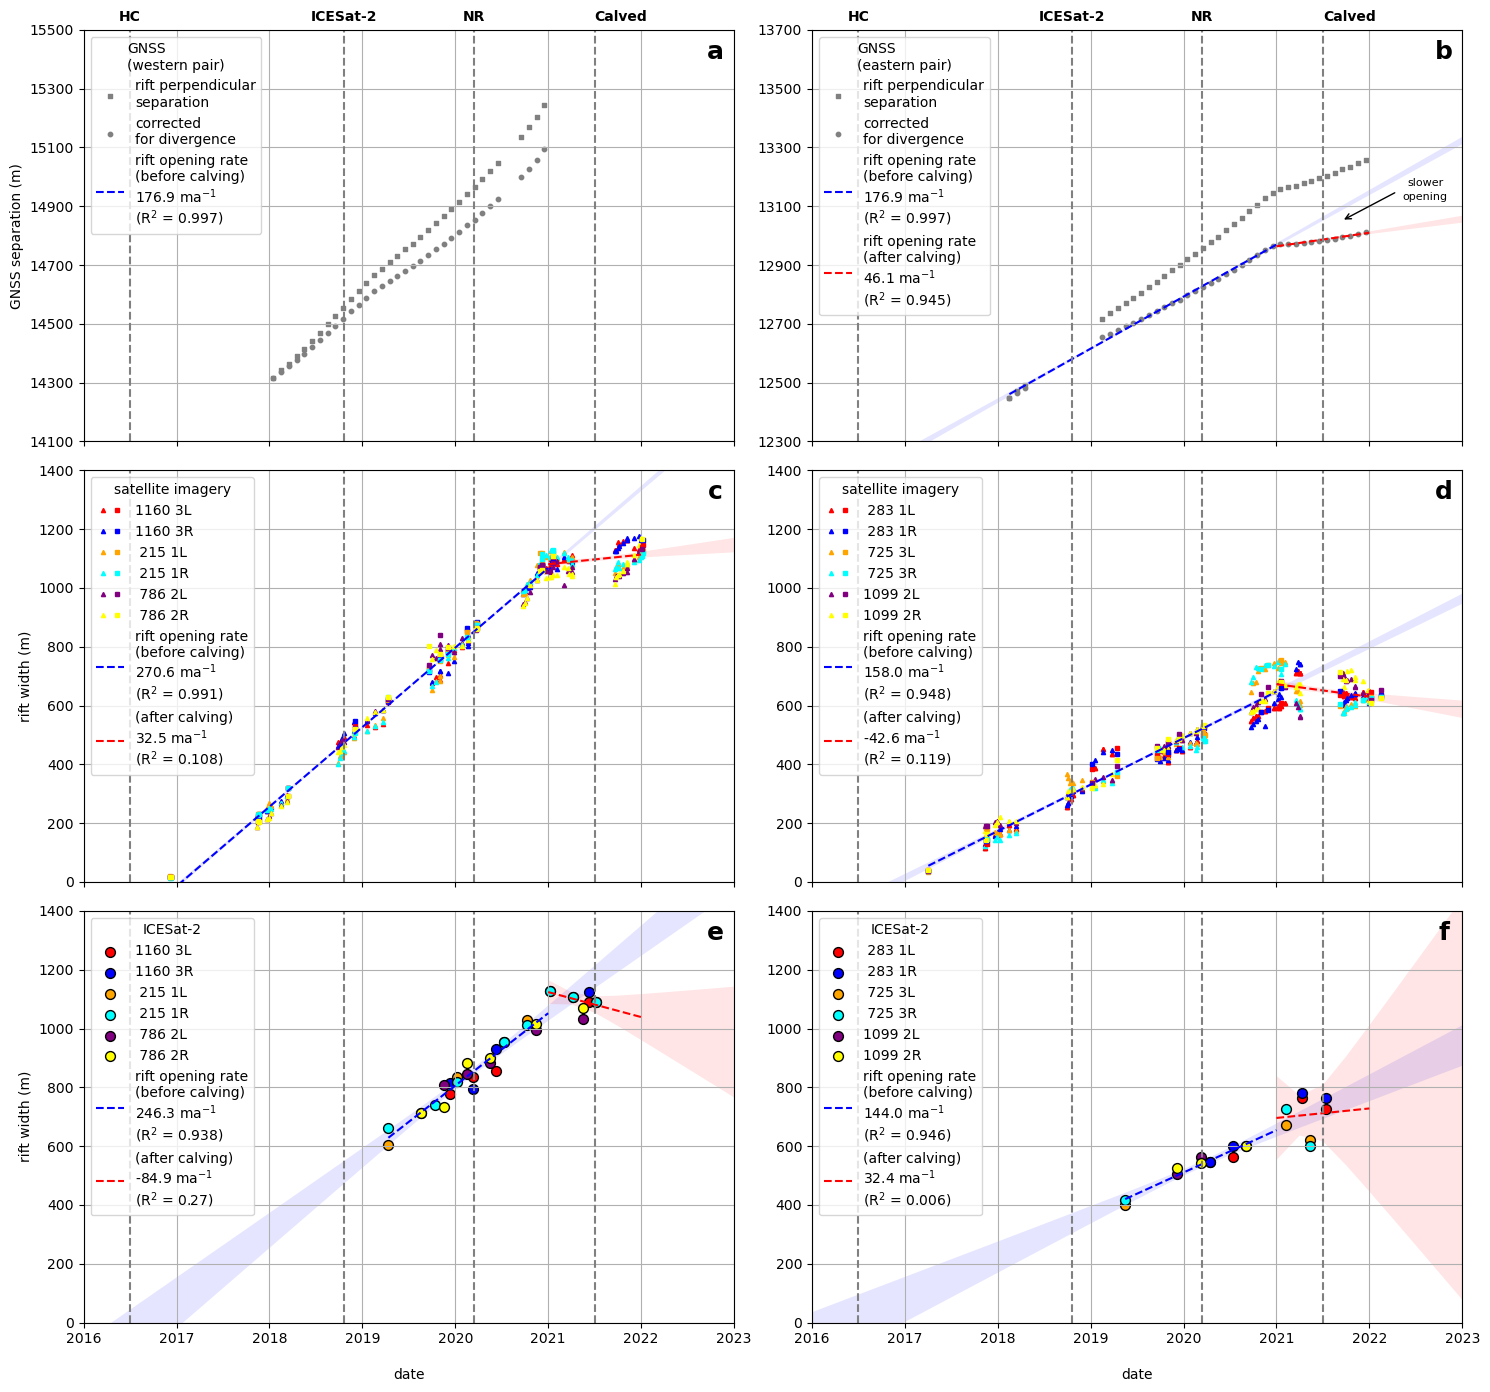

In [36]:
ftsz = 10 #font size

from matplotlib.legend_handler import HandlerLine2D

class HandlerXoffset(HandlerLine2D):
    def __init__(self, marker_pad=0.3, numpoints=1, x_offset=0,  **kw):
        HandlerLine2D.__init__(self, marker_pad=marker_pad, numpoints=numpoints, **kw)
        self._xoffset = x_offset
    def get_xdata(self, legend, xdescent, ydescent, width, height, fontsize):
        numpoints = self.get_numpoints(legend)
        
        if numpoints > 1:
            # we put some pad here to compensate the size of the
            # marker
            xdata = np.linspace(-xdescent + self._marker_pad * fontsize,
                                width - self._marker_pad * fontsize,
                                numpoints) - self._xoffset
            xdata_marker = xdata
        elif numpoints == 1:
            xdata = np.linspace(-xdescent, width, 2) - self._xoffset
            xdata_marker = [0.5 * width - 0.5 * xdescent - self._xoffset]

        return xdata, xdata_marker

fig=plt.figure(figsize=(15,14)) #,sharex='all', sharey='all',figsize=(10,10))

#------------------------------
# top left
ax1=fig.add_subplot(3,2,1)

ax1.fill_between(GNSS_west_pre_t_ls,GNSS_west_pre_conf_int_low,GNSS_west_pre_conf_int_up,facecolor='b',alpha=0.1)

pl_gps = ax1.scatter(hh00_t,actual_hh00_tt05_sep_d,s=10,c='gray',marker='s',label="rift perpendicular\nseparation")
pl_gps_div = ax1.scatter(hh00_t,actual_hh00_tt05_sep_d_div,s=10,c='gray',label="corrected\nfor divergence")
#y=mx+c 2016-2021 P1
pl_lobf = ax1.plot([np.min(hh00_t),div_t],[(wgps_div_slope_PreC*np.min(hh00_t))+wgps_div_inter_PreC,(wgps_div_slope_PreC*div_t)+wgps_div_inter_PreC],'--',color='b',label="rift opening rate\n(before calving)\n"+str(round(wgps_div_slope_PreC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_hh00_tt05_PreC,3))+")")
handles, labels = ax1.get_legend_handles_labels()
order=[1,2,0]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="GNSS\n(western pair)", loc= 'upper left', fontsize=ftsz)

ax1.plot([HC_found,HC_found],[14100,15500],'--',color='0.5')
ax1.text(HC_found,15530,'HC',fontsize=ftsz,weight='bold',ha='center')
ax1.plot([IS_start,IS_start],[14100,15500],'--',color='0.5')
ax1.text(IS_start,15530,'ICESat-2',fontsize=ftsz,weight='bold',ha='center')
ax1.plot([NR_found,NR_found],[14100,15500],'--',color='0.5')
ax1.text(NR_found,15530,'NR',fontsize=ftsz,weight='bold',ha='center')
ax1.plot([NR_calve,NR_calve],[14100,15500],'--',color='0.5')
ax1.text(NR_calve,15530,'Calved',fontsize=ftsz,weight='bold',ha='left')

ax1.set_xlim(2016,2023)
ax1.set_ylim(14100,15500)
ax1.set_yticks([14100,14300,14500,14700,14900,15100,15300,15500])
ax1.grid()

ax1.axes.xaxis.set_ticklabels([])
ax1.set_ylabel("GNSS separation (m)")

ax1.annotate("a",(2022.8,1325+14100),size=18,weight='bold',ha='center',va='center')

#------------------------------
# top right
ax11=fig.add_subplot(3,2,2)

ax11.fill_between(GNSS_east_pre_t_ls,GNSS_east_pre_conf_int_low,GNSS_east_pre_conf_int_up,facecolor='b',alpha=0.1)
ax11.fill_between(GNSS_east_post_t_ls,GNSS_east_post_conf_int_low,GNSS_east_post_conf_int_up,facecolor='r',alpha=0.1)

pl_gps = ax11.scatter(ss00_t,actual_ss00_tt04_sep_d,s=10,c='gray',marker='s',label="rift perpendicular\nseparation")
pl_gps_div = ax11.scatter(ss00_t,actual_ss00_tt04_sep_d_div,s=10,c='gray',label="corrected\nfor divergence")
#y=mx+c 2016-2021 P1 P2 P3 P2P3
pl_lobf = ax11.plot([np.min(ss00_t),div_t],[(egps_div_slope_PreC*np.min(ss00_t))+egps_div_inter_PreC,(egps_div_slope_PreC*div_t)+egps_div_inter_PreC],'--',color='b',label="rift opening rate\n(before calving)\n"+str(round(egps_div_slope_PreC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_ss00_tt04_PreC,3))+")")
#pl_lobf_cont = ax11.plot([np.min(ss00_t),np.max(ss00_t)],[(egps_div_slope_PreC*np.min(ss00_t))+egps_div_inter_PreC,(egps_div_slope_PreC*np.max(ss00_t))+egps_div_inter_PreC],'--',color='b',alpha=0.5)

#pl_lobf_P2 = ax11.plot([NR_div,mid_div],[(egps_div_slope_P2*NR_div)+egps_div_inter_P2,(egps_div_slope_P2*mid_div)+egps_div_inter_P2],'--',color='g',label="estimated\nrift opening rate\n"+str(round(egps_div_slope_P2,1))+" m/yr\n(R$^2$ = "+str(round(r2_ss00_tt04_P2,3))+")")
#pl_lobf_P3 = ax11.plot([mid_div,2022],[(egps_div_slope_P3*mid_div)+egps_div_inter_P3,(egps_div_slope_P3*2022)+egps_div_inter_P3],'--',color='g',label="estimated\nrift opening rate\n"+str(round(egps_div_slope_P3,1))+" m/yr\n(R$^2$ = "+str(round(r2_ss00_tt04_P3,3))+")")
pl_lobf_P2P3 = ax11.plot([div_t,2022],[(egps_div_slope_PostC*div_t)+egps_div_inter_PostC,(egps_div_slope_PostC*2022)+egps_div_inter_PostC],'--',color='r',label="rift opening rate\n(after calving)\n"+str(round(egps_div_slope_PostC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_ss00_tt04_PostC,3))+")")

handles, labels = ax11.get_legend_handles_labels()
order=[2,3,0,1]
ax11.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="GNSS\n(eastern pair)", loc= 'upper left', fontsize=ftsz)

ax11.plot([HC_found,HC_found],[12300,13700],'--',color='0.5')
ax11.text(HC_found,13730,'HC',fontsize=ftsz,weight='bold',ha='center')
ax11.plot([IS_start,IS_start],[12300,13700],'--',color='0.5')
ax11.text(IS_start,13730,'ICESat-2',fontsize=ftsz,weight='bold',ha='center')
ax11.plot([NR_found,NR_found],[12300,13700],'--',color='0.5')
ax11.text(NR_found,13730,'NR',fontsize=ftsz,weight='bold',ha='center')
ax11.plot([NR_calve,NR_calve],[12300,13700],'--',color='0.5')
ax11.text(NR_calve,13730,'Calved',fontsize=ftsz,weight='bold',ha='left')

ax11.set_xlim(2016,2023)
ax11.set_ylim(12300,13700)
ax11.set_yticks([12300,12500,12700,12900,13100,13300,13500,13700])
ax11.grid()

ax11.axes.xaxis.set_ticklabels([])
#ax11.set_ylabel("separation (m)")

ax11.annotate("b",(2022.8,1325+12300),size=18,weight='bold',ha='center',va='center')

#ax11.annotate('', xy=(2021.7,12850), xytext=(2021.7,13050), arrowprops=dict(arrowstyle='<-'))
#ax11.annotate("slower",(2021.7,12800),fontsize=8,ha="center")
#ax11.annotate("opening",(2021.7,12750),fontsize=8,ha="center")

ax11.annotate('', xy=(2022.3,13150), xytext=(2021.7,13050), arrowprops=dict(arrowstyle='<-'))
ax11.annotate("slower",(2022.6,13170),fontsize=8,ha="center")
ax11.annotate("opening",(2022.6,13120),fontsize=8,ha="center")


#inset
#axins11=ax11.inset_axes([0.775, 0.075, 0.2, 0.2])
#axins11.fill_between(GNSS_east_pre_t_ls,GNSS_east_pre_conf_int_low,GNSS_east_pre_conf_int_up,facecolor='b',alpha=0.1)
#axins11.fill_between(GNSS_east_post_t_ls,GNSS_east_post_conf_int_low,GNSS_east_post_conf_int_up,facecolor='r',alpha=0.1)

#axins11.plot([np.min(ss00_t),div_t],[(egps_div_slope_PreC*np.min(ss00_t))+egps_div_inter_PreC,(egps_div_slope_PreC*div_t)+egps_div_inter_PreC],'--',color='b')
#axins11.plot([div_t,2022],[(egps_div_slope_PostC*div_t)+egps_div_inter_PostC,(egps_div_slope_PostC*2022)+egps_div_inter_PostC],'--',color='r')

#axins11.scatter(ss00_t,actual_ss00_tt04_sep_d_div,s=10,c='gray')

#axins11.plot([NR_found,NR_found],[12900,13100],'--',color='0.5')
#axins11.text(NR_found,13010,'NR',fontsize=ftsz,weight='bold',ha='center')
#axins11.plot([NR_calve,NR_calve],[12900,13100],'--',color='0.5')
#axins11.text(NR_calve,13010,'Calved',fontsize=ftsz,weight='bold',ha='center')

#axins11.set_xlim(2020.75,2021.25)
#axins11.set_ylim(12900,13000)
#axins11.set_xticks([2021])
#axins11.set_yticks([])
#axins11.grid()

#ax11.plot([2020.75,2020.75,2021.25,2021.25,2020.75],\
#           [12900,13000,13000,12900,12900],\
#           '--',color='k',linewidth=0.5)


#------------------------------
# middle left
ax2=fig.add_subplot(3,2,3)

ax2.fill_between(sat_west_pre_t_ls,sat_west_pre_conf_int_low,sat_west_pre_conf_int_up,facecolor='b',alpha=0.1)
ax2.fill_between(sat_west_post_t_ls,sat_west_post_conf_int_low,sat_west_post_conf_int_up,facecolor='r',alpha=0.1)

ms=3
ma=1
pl_sat1,  = ax2.plot(wsatd1,wsatw1,'^',mfc='r',mec='r',markersize=ms,alpha=ma)
pl_sat2,  = ax2.plot(wsatd2,wsatw2,'^',mfc='b',mec='b',markersize=ms,alpha=ma)
pl_sat3,  = ax2.plot(wsatd3,wsatw3,'^',mfc='orange',mec='orange',markersize=ms,alpha=ma)
pl_sat4,  = ax2.plot(wsatd4,wsatw4,'^',mfc='cyan',mec='cyan',markersize=ms,alpha=ma)
pl_sat5,  = ax2.plot(wsatd5,wsatw5,'^',mfc='purple',mec='purple',markersize=ms,alpha=ma)
pl_sat6,  = ax2.plot(wsatd6,wsatw6,'^',mfc='yellow',mec='yellow',markersize=ms,alpha=ma)
pl_sat7,  = ax2.plot(wsatd7,wsatw7,'s',mfc='r',mec='r',markersize=ms,alpha=ma)
pl_sat8,  = ax2.plot(wsatd8,wsatw8,'s',mfc='b',mec='b',markersize=ms,alpha=ma)
pl_sat9,  = ax2.plot(wsatd9,wsatw9,'s',mfc='orange',mec='orange',markersize=ms,alpha=ma)
pl_sat10, = ax2.plot(wsatd10,wsatw10,'s',mfc='cyan',mec='cyan',markersize=ms,alpha=ma)
pl_sat11, = ax2.plot(wsatd11,wsatw11,'s',mfc='purple',mec='purple',markersize=ms,alpha=ma)
pl_sat12, = ax2.plot(wsatd12,wsatw12,'s',mfc='yellow',mec='yellow',markersize=ms,alpha=ma)

#y=mx+c 2016-2021 P1 P2 P3 P2P3
pl_lobf, = ax2.plot([np.min(decdate_sat_west),div_t],[(wsat_slope_PreC*np.min(decdate_sat_west))+wsat_inter_PreC,(wsat_slope_PreC*div_t)+wsat_inter_PreC],'--',color='b')

pl_lobf_P2P3, = ax2.plot([div_t,2022],[(wsat_slope_PostC*div_t)+wsat_inter_PostC,(wsat_slope_PostC*2022)+wsat_inter_PostC],'--',color='r')

plt.legend([(pl_sat1,pl_sat7),(pl_sat2,pl_sat8),(pl_sat3,pl_sat9),(pl_sat4,pl_sat10),(pl_sat5,pl_sat11),(pl_sat6,pl_sat12),pl_lobf,pl_lobf_P2P3],\
           ["1160 3L", "1160 3R", " 215 1L", " 215 1R", " 786 2L", " 786 2R","rift opening rate\n(before calving)\n"+str(round(wsat_slope_PreC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_wsat_PreC,3))+")","(after calving)\n"+str(round(wsat_slope_PostC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_wsat_PostC,3))+")"],\
            handler_map={pl_sat1:HandlerXoffset(x_offset=5),   
                         pl_sat7:HandlerXoffset(x_offset=-5),
                         pl_sat2:HandlerXoffset(x_offset=5),   
                         pl_sat8:HandlerXoffset(x_offset=-5),
                         pl_sat3:HandlerXoffset(x_offset=5),   
                         pl_sat9:HandlerXoffset(x_offset=-5),
                         pl_sat4:HandlerXoffset(x_offset=5),   
                         pl_sat10:HandlerXoffset(x_offset=-5),
                         pl_sat5:HandlerXoffset(x_offset=5),   
                         pl_sat11:HandlerXoffset(x_offset=-5),
                         pl_sat6:HandlerXoffset(x_offset=5),   
                         pl_sat12:HandlerXoffset(x_offset=-5)},
                         title="satellite imagery", loc= 'upper left', fontsize=ftsz)


ax2.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax2.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax2.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax2.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')

ax2.set_xlim(2016,2023)
ax2.set_ylim(0,1400)
ax2.grid()

ax2.axes.xaxis.set_ticklabels([])

ax2.annotate("c",(2022.8,1325),size=18,weight='bold',ha='center',va='center')
ax2.set_ylabel("rift width (m)")

#------------------------------
# middle right
ax22=fig.add_subplot(3,2,4)

ax22.fill_between(sat_east_pre_t_ls,sat_east_pre_conf_int_low,sat_east_pre_conf_int_up,facecolor='b',alpha=0.1)
ax22.fill_between(sat_east_post_t_ls,sat_east_post_conf_int_low,sat_east_post_conf_int_up,facecolor='r',alpha=0.1)

ms=3
ma=1
pl_sat1,  = ax22.plot(esatd1,esatw1,'^',mfc='r',mec='r',markersize=ms,alpha=ma)
pl_sat1,  = ax22.plot(esatd1,esatw1,'^',mfc='r',mec='r',markersize=ms,alpha=ma)
pl_sat2,  = ax22.plot(esatd2,esatw2,'^',mfc='b',mec='b',markersize=ms,alpha=ma)
pl_sat3,  = ax22.plot(esatd3,esatw3,'^',mfc='orange',mec='orange',markersize=ms,alpha=ma)
pl_sat4,  = ax22.plot(esatd4,esatw4,'^',mfc='cyan',mec='cyan',markersize=ms,alpha=ma)
pl_sat5,  = ax22.plot(esatd5,esatw5,'^',mfc='purple',mec='purple',markersize=ms,alpha=ma)
pl_sat6,  = ax22.plot(esatd6,esatw6,'^',mfc='yellow',mec='yellow',markersize=ms,alpha=ma)
pl_sat7,  = ax22.plot(esatd7,esatw7,'s',mfc='r',mec='r',markersize=ms,alpha=ma)
pl_sat8,  = ax22.plot(esatd8,esatw8,'s',mfc='b',mec='b',markersize=ms,alpha=ma)
pl_sat9,  = ax22.plot(esatd9,esatw9,'s',mfc='orange',mec='orange',markersize=ms,alpha=ma)
pl_sat10, = ax22.plot(esatd10,esatw10,'s',mfc='cyan',mec='cyan',markersize=ms,alpha=ma)
pl_sat11, = ax22.plot(esatd11,esatw11,'s',mfc='purple',mec='purple',markersize=ms,alpha=ma)
pl_sat12, = ax22.plot(esatd12,esatw12,'s',mfc='yellow',mec='yellow',markersize=ms,alpha=ma)

#y=mx+c 2016-2021 P1 P2 P3 P2P3
pl_lobf, = ax22.plot([np.min(decdate_sat_east),div_t],[(esat_slope_PreC*np.min(decdate_sat_east))+esat_inter_PreC,(esat_slope_PreC*div_t)+esat_inter_PreC],'--',color='b')

pl_lobf_P2P3, = ax22.plot([div_t,2022],[(esat_slope_PostC*div_t)+esat_inter_PostC,(esat_slope_PostC*2022)+esat_inter_PostC],'--',color='r')

plt.legend([(pl_sat1,pl_sat7),(pl_sat2,pl_sat8),(pl_sat3,pl_sat9),(pl_sat4,pl_sat10),(pl_sat5,pl_sat11),(pl_sat6,pl_sat12),pl_lobf,pl_lobf_P2P3],\
           [" 283 1L", " 283 1R", " 725 3L", " 725 3R", "1099 2L", "1099 2R","rift opening rate\n(before calving)\n"+str(round(esat_slope_PreC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_esat_PreC,3))+")","(after calving)\n"+str(round(esat_slope_PostC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_esat_PostC,3))+")"],\
            handler_map={pl_sat1:HandlerXoffset(x_offset=5),   
                         pl_sat7:HandlerXoffset(x_offset=-5),
                         pl_sat2:HandlerXoffset(x_offset=5),   
                         pl_sat8:HandlerXoffset(x_offset=-5),
                         pl_sat3:HandlerXoffset(x_offset=5),   
                         pl_sat9:HandlerXoffset(x_offset=-5),
                         pl_sat4:HandlerXoffset(x_offset=5),   
                         pl_sat10:HandlerXoffset(x_offset=-5),
                         pl_sat5:HandlerXoffset(x_offset=5),   
                         pl_sat11:HandlerXoffset(x_offset=-5),
                         pl_sat6:HandlerXoffset(x_offset=5),   
                         pl_sat12:HandlerXoffset(x_offset=-5)},
                         title="satellite imagery", loc= 'upper left', fontsize=ftsz)

ax22.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax22.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax22.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax22.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')

ax22.set_xlim(2016,2023)
ax22.set_ylim(0,1400)
ax22.grid()

ax22.axes.xaxis.set_ticklabels([])

ax22.annotate("d",(2022.8,1325),size=18,weight='bold',ha='center',va='center')
#ax22.set_ylabel("rift width (m)")

#------------------------------
# bottom left
ax3=fig.add_subplot(3,2,5)

ax3.fill_between(IS2_west_pre_t_ls,IS2_west_pre_conf_int_low,IS2_west_pre_conf_int_up,facecolor='b',alpha=0.1)
ax3.fill_between(IS2_west_post_t_ls,IS2_west_post_conf_int_low,IS2_west_post_conf_int_up,facecolor='r',alpha=0.1)

ms=50
ma=1
pl_is21  = ax3.scatter(decdate_sub_1160_3l,width_1160_3l,edgecolor='k',s=ms,alpha=ma,color='r',label="1160 3L")      #1160 3l is2 red
pl_is22  = ax3.scatter(decdate_sub_1160_3r,width_1160_3r,edgecolor='k',s=ms,alpha=ma,color='b',label="1160 3R")      #1160 3r is2 blue
pl_is23  = ax3.scatter(decdate_sub_215_1l,width_215_1l,edgecolor='k',s=ms,alpha=ma,color='orange',label=" 215 1L")   #215  1l is2 orange
pl_is24  = ax3.scatter(decdate_sub_215_1r,width_215_1r,edgecolor='k',s=ms,alpha=ma,color='cyan',label=" 215 1R")     #215  1r is2 cyan
pl_is25  = ax3.scatter(decdate_sub_786_2l,width_786_2l,edgecolor='k',s=ms,alpha=ma,color='purple',label=" 786 2L")   #786  2l is2 'red'
pl_is26  = ax3.scatter(decdate_sub_786_2r,width_786_2r,edgecolor='k',s=ms,alpha=ma,color='yellow',label=" 786 2R")   #786  2r is2 'blue'

#y=mx+c 2016-2021 P1 P2 P2P3
pl_lobf = ax3.plot([np.min(decdate_sub_is2_west),div_t],[(wis2_slope_PreC*np.min(decdate_sub_is2_west))+wis2_inter_PreC,(wis2_slope_PreC*div_t)+wis2_inter_PreC],'--',color='b',label="rift opening rate\n(before calving)\n"+str(round(wis2_slope_PreC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_wis2_PreC,3))+")")

pl_lobf_P2P3 = ax3.plot([div_t,2022],[(wis2_slope_PostC*div_t)+wis2_inter_PostC,(wis2_slope_PostC*2022)+wis2_inter_PostC],'--',color='r',label="(after calving)\n"+str(round(wis2_slope_PostC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_wis2_PostC,3))+")")

handles, labels = ax3.get_legend_handles_labels()
order=[2,3,4,5,6,7,0,1]
ax3.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="ICESat-2", loc= 'upper left', fontsize=ftsz)

ax3.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax3.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax3.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax3.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')

ax3.set_xlim(2016,2023)
ax3.set_ylim(0,1400)
ax3.grid()

ax3.annotate("e",(2022.8,1325),size=18,weight='bold',ha='center',va='center')
ax3.set_ylabel("rift width (m)")
ax3.set_xlabel("\ndate")

#------------------------------
# bottom right
ax33=fig.add_subplot(3,2,6)

ax33.fill_between(IS2_east_pre_t_ls,IS2_east_pre_conf_int_low,IS2_east_pre_conf_int_up,facecolor='b',alpha=0.1)
ax33.fill_between(IS2_east_post_t_ls,IS2_east_post_conf_int_low,IS2_east_post_conf_int_up,facecolor='r',alpha=0.1)

ms=50
ma=1
pl_is21  = ax33.scatter(decdate_sub_283_1l,width_283_1l,edgecolor='k',s=ms,alpha=ma,color='r',label=" 283 1L")          #283  1l is2 red
pl_is22  = ax33.scatter(decdate_sub_283_1r,width_283_1r,edgecolor='k',s=ms,alpha=ma,color='b',label=" 283 1R")          #283  1r is2 blue
pl_is23  = ax33.scatter(decdate_sub_725_3l,width_725_3l,edgecolor='k',s=ms,alpha=ma,color='orange',label=" 725 3L")     #725  3l is2 orange
pl_is24  = ax33.scatter(decdate_sub_725_3r,width_725_3r,edgecolor='k',s=ms,alpha=ma,color='cyan',label=" 725 3R")       #725  3r is2 cyan
pl_is25  = ax33.scatter(decdate_sub_1099_2l,width_1099_2l,edgecolor='k',s=ms,alpha=ma,color='purple',label="1099 2L")   #1099 2l is2 'red'
pl_is26  = ax33.scatter(decdate_sub_1099_2r,width_1099_2r,edgecolor='k',s=ms,alpha=ma,color='yellow',label="1099 2R")   #1099 2r is2 'blue'

#y=mx+c 2016-2021 P1 P2 P2P3
pl_lobf = ax33.plot([np.min(decdate_sub_is2_east),div_t],[(eis2_slope_PreC*np.min(decdate_sub_is2_east))+eis2_inter_PreC,(eis2_slope_PreC*div_t)+eis2_inter_PreC],'--',color='b',label="rift opening rate\n(before calving)\n"+str(round(eis2_slope_PreC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_eis2_PreC,3))+")")

pl_lobf_P2P3 = ax33.plot([div_t,2022],[(eis2_slope_PostC*div_t)+eis2_inter_PostC,(eis2_slope_PostC*2022)+eis2_inter_PostC],'--',color='r',label="(after calving)\n"+str(round(eis2_slope_PostC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_eis2_PostC,3))+")")

handles, labels = ax33.get_legend_handles_labels()
order=[2,3,4,5,6,7,0,1]
ax33.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="ICESat-2", loc= 'upper left', fontsize=ftsz)

ax33.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax33.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax33.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax33.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')

ax33.set_xlim(2016,2023)
ax33.set_ylim(0,1400)
ax33.grid()

ax33.annotate("f",(2022.8,1325),size=18,weight='bold',ha='center',va='center')
#ax33.set_ylabel("rift width (m)")
ax33.set_xlabel("\ndate")


plt.tight_layout()

output = figure_folder+'/fig06_lobf_graph_calve_div.png'
plt.savefig(output, dpi=100, bbox_inches='tight')

plt.show()

## Compute the standard deviation of the rates

In [37]:
# Function to compute 1-sigma (standard error of the slope)
def compute_sigma(x, y, slope, intercept):
    n = len(x)
    y_pred = slope * x + intercept
    residuals = y - y_pred
    std_error_res = np.sqrt(np.sum(residuals**2) / (n - 2))
    se_slope = std_error_res / np.sqrt(np.sum((x - np.mean(x))**2))
    return se_slope

# GNSS - Western pair (pre-calving)
sigma_west = compute_sigma(np.array(hh00_t), np.array(actual_hh00_tt05_sep_d_div), wgps_div_slope_PreC, wgps_div_inter_PreC)
print(f"Western GNSS regression (pre-calving) 1-sigma: {sigma_west}")

# GNSS - Eastern pair (pre-calving)
sigma_east_pre = compute_sigma(np.array(ss00_t), np.array(actual_ss00_tt04_sep_d_div), egps_div_slope_PreC, egps_div_inter_PreC)
print(f"Eastern GNSS regression (pre-calving) 1-sigma: {sigma_east_pre}")

# GNSS - Eastern pair (post-calving)
sigma_east_post = compute_sigma(np.array(ss00_t), np.array(actual_ss00_tt04_sep_d_div), egps_div_slope_PostC, egps_div_inter_PostC)
print(f"Eastern GNSS regression (post-calving) 1-sigma: {sigma_east_post}")

# ICESat-2 - Western pair (pre-calving)
sigma_is2_west_pre = compute_sigma(np.array(decdate_sub_1160_3l), np.array(width_1160_3l), wis2_slope_PreC, wis2_inter_PreC)
print(f"ICESat-2 Western (pre-calving) 1-sigma: {sigma_is2_west_pre}")

# ICESat-2 - Western pair (post-calving)
sigma_is2_west_post = compute_sigma(np.array(decdate_sub_1160_3l), np.array(width_1160_3l), wis2_slope_PostC, wis2_inter_PostC)
print(f"ICESat-2 Western (post-calving) 1-sigma: {sigma_is2_west_post}")

# ICESat-2 - Eastern pair (pre-calving)
sigma_is2_east_pre = compute_sigma(np.array(decdate_sub_283_1l), np.array(width_283_1l), eis2_slope_PreC, eis2_inter_PreC)
print(f"ICESat-2 Eastern (pre-calving) 1-sigma: {sigma_is2_east_pre}")

# ICESat-2 - Eastern pair (post-calving)
sigma_is2_east_post = compute_sigma(np.array(decdate_sub_283_1l), np.array(width_283_1l), eis2_slope_PostC, eis2_inter_PostC)
print(f"ICESat-2 Eastern (post-calving) 1-sigma: {sigma_is2_east_post}")

# Satellite - Western (pre-calving)
sigma_sat_west_pre = compute_sigma(np.array(wsatd1), np.array(wsatw1), wsat_slope_PreC, wsat_inter_PreC)
print(f"Satellite Western (pre-calving) 1-sigma: {sigma_sat_west_pre}")

# Satellite - Western (post-calving)
sigma_sat_west_post = compute_sigma(np.array(wsatd1), np.array(wsatw1), wsat_slope_PostC, wsat_inter_PostC)
print(f"Satellite Western (post-calving) 1-sigma: {sigma_sat_west_post}")

# Satellite - Eastern (pre-calving)
sigma_sat_east_pre = compute_sigma(np.array(esatd1), np.array(esatw1), esat_slope_PreC, esat_inter_PreC)
print(f"Satellite Eastern (pre-calving) 1-sigma: {sigma_sat_east_pre}")

# Satellite - Eastern (post-calving)
sigma_sat_east_post = compute_sigma(np.array(esatd1), np.array(esatw1), esat_slope_PostC, esat_inter_PostC)
print(f"Satellite Eastern (post-calving) 1-sigma: {sigma_sat_east_post}")

Western GNSS regression (pre-calving) 1-sigma: 412.73608851437035
Eastern GNSS regression (pre-calving) 1-sigma: 7.445303506224079
Eastern GNSS regression (post-calving) 1-sigma: 24.156710624109348
ICESat-2 Western (pre-calving) 1-sigma: 60.09355907607637
ICESat-2 Western (post-calving) 1-sigma: 404.88645732049173
ICESat-2 Eastern (pre-calving) 1-sigma: 50.07259042465222
ICESat-2 Eastern (post-calving) 1-sigma: 126.6720331831823
Satellite Western (pre-calving) 1-sigma: 8.208713132819891
Satellite Western (post-calving) 1-sigma: 40.88135211901139
Satellite Eastern (pre-calving) 1-sigma: 8.384109827776845
Satellite Eastern (post-calving) 1-sigma: 36.52789011100736
